# **Module 7 Final Project Notebook - Group 28**
**Tim Beer & Lee McFarling**

Boston Univeristy

DX703: Advanced Machine Learning & AI

December 7, 2025

**Description: Machine Learning pipeline to classify HuffPost articles based on Headlines and Short Descriptions**

# **Table of Contents**

With our final model structure and methogoloy in mind, to keep things organized, we will split our final notebook into the following sections with three overarching categories:

**A.1 Setup and Context**

0) Introduction
1) Useful Package and Data Imports
2) Data Cleaning and Pre-Processing
3) Pre-Model Training
    - Round One - Frozen Backbone
    - Round Two - Un-Frozen Backbone
4) Pre-Model Preliminary Results
5) Final 'Input' Dataset Preparation

**A.2 Model Selection and Retraining**

6) Final Model Training
    - Round One - Frozen Backbone
    - Round Two - Un-Frozen Backbone

**A.3 Model Evaluation and Visualization**

7) Final Model Results and Discussion
8) Further Research Directions

9) Appendix (Post Milestone 2 Experiments and Modeling Decisions)

___

# **A.1: Setup and Context**

## **Section 0: Introduction**

### **Purpose: Huffington Post News Category Predictions**

Our final project consists of a multi-label classification task performed on the HuffPost News Category dataset. Each of the (approx.) 200,000 records in our dataset contains a headline, a short description, and other information and is labeled with one of 41 different class labels.

Our job is to build a pipeline that can automatically assign an article to a given category given a headline and a short description. This task has a variety of useful applications from automatic labeling of text based social media posts, categorization of other news articles, screening a variety of news sources and aggregating by category (as done in aggregators like Ground News) and so on. In this notebook we will import the raw data, discuss any decisions we made about cleaning and pre-processing the data, then train and test our final model to completion. Additionally, we will discuss our architectural choices in modeling and walk through our various experiments that led to our final prediction.

### **Brief Summary of Milestones 1 & 2:**

In milestone 1, we obtained the dataset and performed an exploratory data analysis on it to determine which pre-processing steps were needed before modeling occured, we found a number of categories that could be consolidated, as well as other features like max_token length which will be discussed later as these decisions come into play. Additionally, all of our experiments post milestone 2 that led us to our final model architechture are detailed explicitly in Appendix A. 

In milestone 2, after data cleaning and pre-processing, we had tried 3 different pre-trained transformer model iterations: BertBASE, Distil-BERT, and Distil-Bert + a Custom head. All three of the models had Test Accuracies around 68% with the formal rankings being:

- BertBASE:                  68.93% Test Accuracy
- Distil-BERT:               68.71% Test Accuracy
- Distil-Bert + Custom Head: 68.56% Test Accuracy

We chose to go with the DistilBERT + Custom Head as it was negligibly under the other two in performance, it gave us the best amount of personalization options for our dataset, and it was much quicker to train than using the BertBASE model (often training 33% faster). Our 'base' model architecture was extremely light in this regard, a single dense layer of 256 neurons + a single layer of dropout (0.3). This gave us a good base to work off of, and from the first experiment onwards, we iterated off of this structure to acieve our final workable model.

### **Note on Final Model Structure**

In accordance with our data remediation strategy detailed in [Appendix A, Experiment 9] our model training procedure will take the following structure:

We will split our data into two DataFrames (One with the 'Impact' category only, the other without the impact category). From there we will train a model on a subset of the data, use that resulting model to re-assign (predict) 'impact' articles as if the category never existed, and then we will re-combine these re-assigned articles with our original subset to train a final model using our best methodologies.


**To Illustrate:**

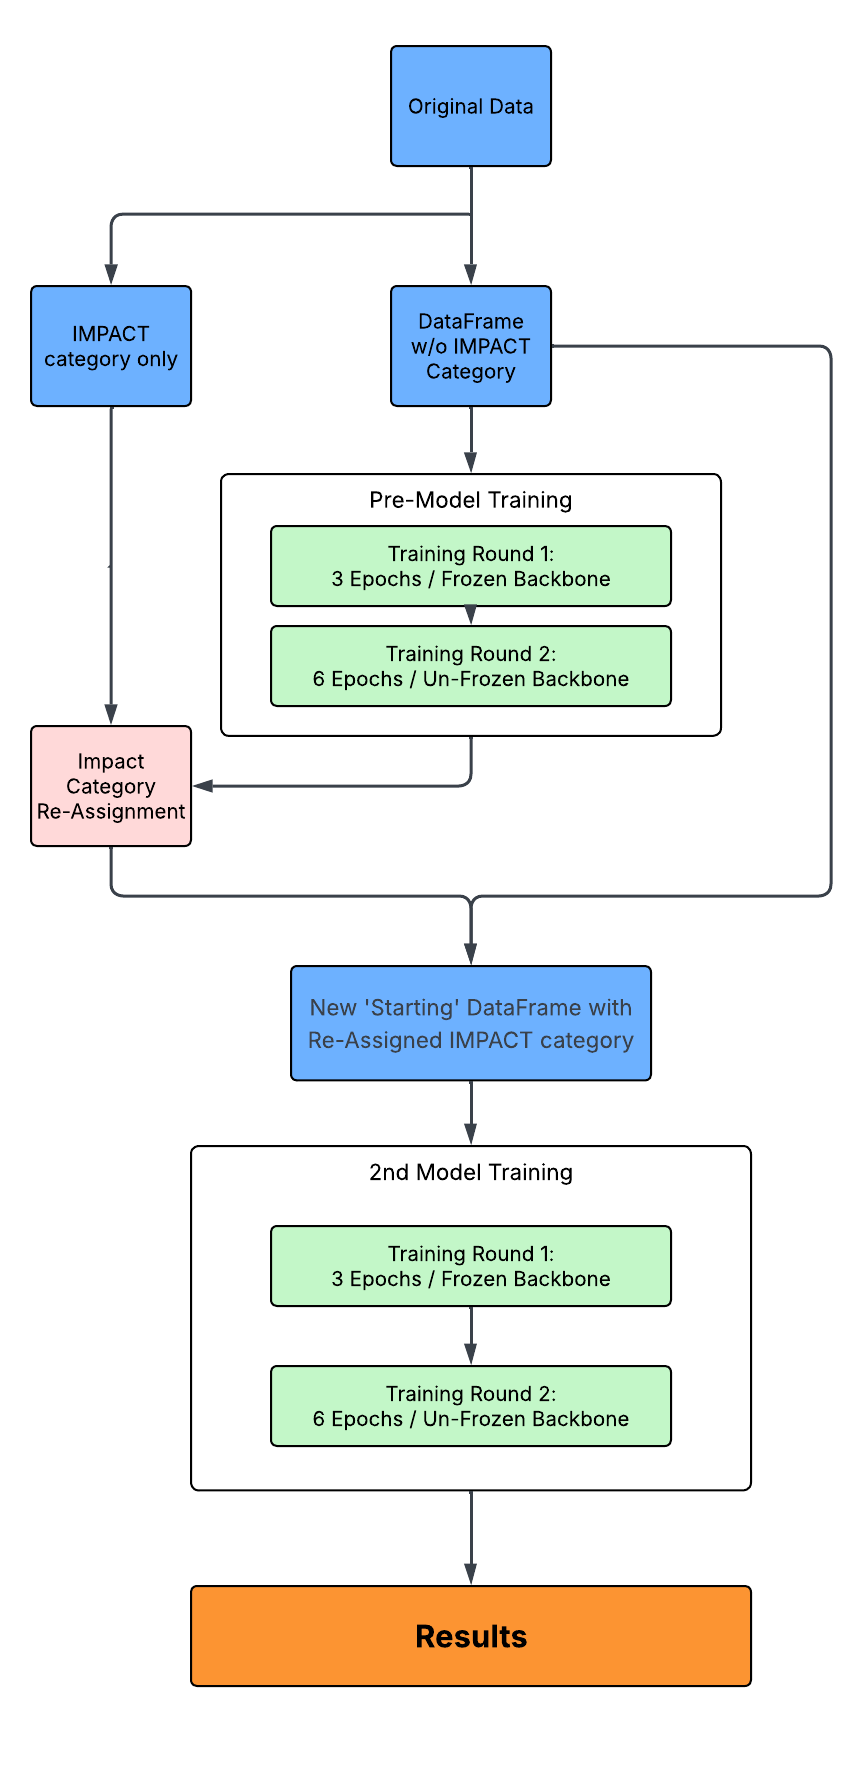


As mentioned earlier, our decisions for how we arrived at this final model architecture, model training regimine, and data-preprocessing are all discussed at length in Appendix A. For efficiency, our sections here will henceforth focus on explaining steps as they occur, with code commenting and explainations. An at length explanation of *why* those decisions were made is made available to the reader at the end of the notebook.

___

# **Section 1: Useful Package and Data Imports**

#### **Package Imports**

In [45]:
# Standard Stuff
import os
import time
import random
from collections import Counter
from tqdm import tqdm

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# NLP / Tokenization
import spacy

# TensorFlow / Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)
import keras_hub as kh
from tensorflow import keras

# SK Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



# Global Regularization and Utilities
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.keras.utils.set_random_seed(SEED)   # sets Python, NumPy, and TensorFlow seeds


# Further Utility Function for time tracking:
def format_hms(seconds: float) -> str:
    """Convert seconds to HH:MM:SS format."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### **Dataset Imports**

And from here, we will import our dataset, starting with the hugging face imports:

In [4]:
from datasets import load_dataset, DatasetDict
from datasets.features import ClassLabel

And the dataset itself from a JSON Mirror:

In [5]:
# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

# And a quick print of heuristics
print(f"HuffPost Columns: {huff_all.column_names}")
print(f"Total rows: {len(huff_all):,}")

# And then we'll convert it to a DataFrame for the rest of the pipeline
df = huff_all.to_pandas()
df = df[["headline","short_description","category","authors","link","date"]].copy()
df_eda = df.copy()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


News_Category_Dataset_v2.json:   0%|          | 0.00/83.9M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

HuffPost Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200,853


___

# **Section 2: Dataset Cleaning and Pre-Processing**

From here, we'll clean and process a number of issues that were identified in Milestone 1. Regarding the pre-processing we will drop columns like author, link, and date, as they are not part of this classification task. Then we'll concatenate the headline and short description together to act as our model features, and retain the 'category' column to act as our target.

#### **Data Preprocessing**

Here, the we'll utilize a clean_text function to return an empty string (if null or N/A); trim any leading or trailing whitespaces; normalize any internal white spaces to be in the format of " ", and then return all lower cases.

 For example:
 -  **Before: " Lorem\n Ipsum ..."**
 -   **After:  "lorem ipsum ..."**

In [6]:
def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    return " ".join(s.split())

# Concatenate headline + summary, then clean
text = (df["headline"].fillna("") + " " + df["short_description"].fillna("")).apply(clean_text)

#### **Data Cleaning**

Here we will remove blank rows, drop any duplicates, and then format our category columns to remove any weird strings.

In [7]:
# Remove any empty samples
mask_nonempty = text.str.len() > 0
df = df.loc[mask_nonempty].copy()
df["text"] = text[mask_nonempty].values

# Drop any Duplicates (and count dropped rows for record keeping)
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicate rows; remaining = {after}")


# Format category columns to ameliorate any weird strings
df["category"] = (
    df["category"]
    .fillna("")
    .str.strip()
    .str.upper()
    .str.replace("’", "'", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)


Removed 492 duplicate rows; remaining = 200356


And once that is done, we will apply our data-cleaning step to consolidate any categories that were identified in Milestone 1 as having a high lexical overlap (as revealed by Jaccard similarity). As detailed in **Appendix A**, we returned to this step to revisit consolidating categories with a high *semantic* overlap in terms of subject matter subsequent to the second milestone. The final consolidation strategy is below:

NOTE: As we'll discuss later, there were several rounds of this after maximizing the amount of performance we could get from architectural / and training regimine changes alone. The label consolidations are organized by category, and denoted with labels corresponding to the 'round' in which they were added.

#### **Label Consolidation**

In [8]:
# Consolidate Classes from Milestone 1
map_to = {
    # Arts & Entertainment
    "ARTS": "ARTS & ENTERTAINMENT",
    "ARTS & CULTURE": "ARTS & ENTERTAINMENT",
    "CULTURE & ARTS": "ARTS & ENTERTAINMENT",
    "ENTERTAINMENT": "ARTS & ENTERTAINMENT",

    # Health & Wellness
    "WELLNESS": "HEALTH & WELLNESS",
    "HEALTHY LIVING": "HEALTH & WELLNESS",
    "FIFTY": "HEALTH & WELLNESS",               # ADDED AFTER SECOND ROUND

    # Food & Drink
    "FOOD & DRINK": "FOOD & DRINK",
    "FOOD & DRINK.": "FOOD & DRINK",
    "TASTE": "FOOD & DRINK",

    # Family & Relationships
    "PARENTING": "FAMILY & RELATIONSHIPS",
    "PARENTS": "FAMILY & RELATIONSHIPS",
    "DIVORCE": "FAMILY & RELATIONSHIPS",
    "WEDDINGS": "FAMILY & RELATIONSHIPS",

    # World News
    "WORLDPOST": "WORLD NEWS",
    "THE WORLDPOST": "WORLD NEWS",

    # Environment
    "GREEN": "ENVIRONMENT",

    # Business & Money
    "BUSINESS": "BUSINESS & MONEY",
    "MONEY": "BUSINESS & MONEY",

    # Education
    "COLLEGE": "EDUCATION",

    # Regarding Voices and Identity
    "BLACK VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND [Appendix A]
    "LATINO VOICES": "VOICES & IDENTITY",         # ADDED AFTER SECOND ROUND [Appendix A]
    "QUEER VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND [Appendix A]
    "WOMEN": "VOICES & IDENTITY",                 # ADDED AFTER **THIRD** ROUND [Appendix A]



    # 'Other' Categories
    "GOOD NEWS": "OTHER NEWS",                  # ADDED AFTER SECOND ROUND - [Appendix A]
    "WEIRD NEWS": "OTHER NEWS",                 # ADDED AFTER SECOND ROUND - [Appendix A]

    # Tried this one but it resulted in worse model performance [Appendix A]
    # For Illustration, it is still here but commented out
    # "STYLE": "STYLE & BEAUTY"
}


# Replace using the mapping, leave others untouched
df["label_str"] = df["category"].replace(map_to)
df = df[["text","label_str","authors","link","date"]]



# Seperating 'Impact' and 'No Impact' Categories
df_no_impact = df[df["label_str"]!="IMPACT"].copy()
df_impact   = df[df["label_str"]=="IMPACT"].copy()


# Temporarily re-assigning df to our 'no-impact' data (we'll use our first model to re-classify and then revisit later)
df = df_no_impact



df.head(3)

,text,label_str,authors,link,date
0,there were 2 mass shootings in texas last week...,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,will smith joins diplo and nicky jam for the 2...,ARTS & ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,hugh grant marries for the first time at age 5...,ARTS & ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26


At this point, as a sanity check, we printed out the Categories along with the aggregated amount of records for each after the label consolidation. This was meant to give us a quick look at how many categories were left after consolidation  (from the original 41), as well as the new relative class imbalance.

In [9]:
print(f"Unique labels (after consolidation): {len(df["label_str"].unique())}\n")
print(df["label_str"].value_counts().head(25))

# And quick double check that we got all of the empty rows
print("\n Any empty texts left? ", (df["text"].str.len()==0).sum())

Unique labels (after consolidation): 22

label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
COMEDY                     5163
SPORTS                     4884
HOME & LIVING              4161
OTHER NEWS                 4068
ENVIRONMENT                3939
CRIME                      3401
MEDIA                      2812
RELIGION                   2548
STYLE                      2246
SCIENCE                    2178
EDUCATION                  2148
TECH                       2033
Name: count, dtype: int64

 Any empty texts left?  0


And next, we'll pre process our target by taking the unique categories, alphabetizing them, and and then doing some integer encoding to get them to play nicely with our Transformer.

In [10]:
# Alphabetize
cats = sorted(df["label_str"].unique())

# Encode Categories
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

And here, we'll include the logic for training subsets of the dataset to cut down on computation costs during our experiments. (It's set to 100% for the final run).

In [11]:
# Our running percentage of the dataset we're training on
SUBSET_FRAC = 1.0

# splits the dataset using SK learns traintest split
if 0.0 < SUBSET_FRAC < 1.0:
    df_pool, _ = train_test_split(
        df,
        train_size=SUBSET_FRAC,
        random_state=SEED,
        stratify=df["label"],
    )
else:
    df_pool = df

# And sanity checks
print(f"Pool after SUBSET_FRAC={SUBSET_FRAC}: {len(df_pool)} (of {len(df)})")
print("Label distribution in pool (first 10):")
print(df_pool["label"].value_counts().head(10))

Pool after SUBSET_FRAC=1.0: 196899 (of 196899)
Label distribution in pool (first 10):
label
12    32721
8     25911
0     19930
6     19618
20    15366
19     9883
17     9512
21     8418
7      8320
1      7639
Name: count, dtype: int64


#### **Feature Tokenization**

Here we tokenize our feature inputs and apply a max_length cap to our inputs for BERT. Final decisions for this are discussed in Appendix A, Experiment 8.

In [12]:
# First Tokenize, and then get a feel for the counts
token_counts = df["text"].str.split().apply(len)
# Originally used to get the 95th percentile to impose a hard cap on tokens
# but changed to 128 hard cap in Experiment 8 - Details in Appendix A
p95 = int(np.percentile(token_counts, 95))
MAX_LENGTH = 128

print(f"Classes: {len(cats)} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))


Classes: 22 | p95=55 → MAX_LENGTH=128
label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
Name: count, dtype: int64


Now we can train-test split our dataset using an 80 / 10 / 10 split for training, validation, and testing respectively.

In [13]:
# Stratified 80/10/10 splits

# filter DF to just our features and target
X = df["text"].values
y = df["label"].values

# Train vs temp (later split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Split the Temp into Val and Test 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")

Train/Val/Test sizes: 157519 / 19690 / 19690


#### **Class Weighting**

Here, because our dataset is extremely unbalanced, we'll create a class weight dictionary to make up for the fact that some categories have 16 times as many records as others

In [14]:
classes = np.arange(len(cats))

# Apply SKlearn's balanced class weights
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]

[(0, 0.4490689002417552),
 (1, 1.1716502283512593),
 (2, 1.733645168390931),
 (3, 2.6313688149410313),
 (4, 4.16518589031678),
 (5, 2.27228008424454),
 (6, 0.4562224127344556),
 (7, 1.0757143247377623),
 (8, 0.3454076195404769),
 (9, 2.1507823807313144)]

And next, we'll do a final preparation for our dataset to go into our BERT pre-processing layer. Our model pre-processing layer needs an input list of tuple pairs of features ({dictionary of "text": x}) and targets (integer). To accomplish this, we made a function called make_ds_bert() and then applied that function to our training, validation, and test sets (ds_train_bert, ds_val_bert, etc.). Finally, we included some more sanity checks to ensure that everything is working correctly.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32

# prepare the tuple (input "text", output label structure)
def make_ds_bert(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_BERT, drop_remainder=False)

    # Match the BERT model's input: "text"
    ds = ds.map(lambda x, y: ({"text": x}, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

# apply function to our training and validation splits
ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)
ds_test_bert = make_ds_bert(X_test, y_test, shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


____

# **Section 3: Pre-Model Training**

#### **Quick Note on Architecture**

For our modeling, we chose to go with a pre-trained Distil-BERT model with a custom head architecture as detailed below. This architecture was settled on by conducting a number of different experiements, the results of which are in Appendix A. To review, the architecture is as follows:

**Base Model**

- Distil-BERT

(Forgo Bert's Built-In classification and use our own)

**Custom Classification Head**

- 1028 Dense layer (ReLu) Activation
    - Dropout (0.3)
- 512 Dense layer (ReLu) Activation
    - Dropout (0.3)
- 256 Dense layer (ReLu) Activation




In [ ]:
# Quick Pulls from Earlier

NUM_CLASSES = len(cats) # Number of Categories post Cleaning
MAX_LEN     = MAX_LENGTH # Hard Cap on token length (from our 95% earlier)


# Distill BERT Pipeline
preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)


# Model Inputs
text_in  = keras.Input(shape=(), dtype="string", name="text") # Input Raw Strings of MAX_LEN (our 95%)
tokens   = preproc(text_in)

backbone = pipeline.get_layer("distil_bert_backbone")
backbone.trainable = True         # We'll change this later

seq_out  = backbone(tokens)       # Bert output (B, T, 768)

# Bypass Bert's Classification Layer and use our own head instead
cls    = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)

# Our Custom Classification Head
x      = layers.Dense(1028, activation="relu")(cls)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(512, activation="relu")(x)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(256, activation="relu")(x)

logits = layers.Dense(NUM_CLASSES, activation=None, name="logits")(x)

# Name it to call for summary later
bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

# And summarize
bertinator.summary()

Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 128),     │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 128, 768)  │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1028)      │    790,532 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1028)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    526,848 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 22)        │      5,654 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,817,242 (258.70 MB)

 Trainable params: 67,817,242 (258.70 MB)

 Non-trainable params: 0 (0.00 B)

#### **Pre-Model Training - Round One: Frozen BackBone**

**Quick Note on Training Strategies**

Because our dataset consists of a pre-trained transformer with a custom classification head, and in order to take care of any vanishing gradient issues,  we will split training up into two rounds. For the first round, we'll freeze the backbone and only train the classification head. To prevent overfitting, we'll only do this for 3 epochs. Then during a second round of training, we'll unfreeze the backbone of the pre-trained model, and train the whole network together. Again this strategy was a result of experiments post-milestone 2, and the details of this are articulated in Appendix A.

In [17]:
# Compile the Bert Backbone - This time, we compile it as frozen with a high LR
backbone.trainable = False                                           # Frozen :)
bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),             # High LR this time (for the head)
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)


# Start Training Timer
start = time.time()

# We'll hard cap the epochs at 3 this time (and will train more later)
EPOCHS = 3

# We'll also use Early Stopping as a failsafe to prevent overfitting
# (even though that's not expected with only 3 epochs this round)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


history = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,       # Use our class weights from Earlier
    callbacks=cb,                     # Only early stopping as it's a warm up
    verbose=2,                        # Setting verbose to 2 to cut down on Colab log spam
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)


4923/4923 - 111s - 23ms/step - accuracy: 0.4753 - loss: 1.6738 - val_accuracy: 0.5737 - val_loss: 1.4177
Epoch 2/3
4923/4923 - 98s - 20ms/step - accuracy: 0.5324 - loss: 1.4967 - val_accuracy: 0.5764 - val_loss: 1.4017
Epoch 3/3
4923/4923 - 97s - 20ms/step - accuracy: 0.5416 - loss: 1.4579 - val_accuracy: 0.5802 - val_loss: 1.4385
Elapsed Time: 5.10 min


#### **Pre-Model Training -  Round two: UnFrozen Backbone**

**Another Quick note on strategy**

This time we will re-compile with an *unfrozen* backbone and a lower baseline learning rate and then we will train for a maximum of 6 more epochs. Throughout the course of our experiments, we tried several different setups and settled on the following methodology:


- Hard Cap of 6 epochs (this round) this was originally lower, but the model training was consistantly using all available training rounds.

*Callbacks*
- Early stopping to prevent overfitting (if no improvement stop early)
- Reduce on Plateau again to dial back the learning rate and reduce overfitting as we've already trained the classification head in isolation.

As before, these decisions are articulated in Appendix A.



In [18]:
# Re-Compile wiht an unfrozen backbone this time
backbone.trainable = True

bertinator.compile(
    optimizer=keras.optimizers.Adam(2e-5), # lower starting LR this time to prevent overfitting
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=False
)

# And fit a second time
start = time.time()

# Bumped the max up to 6 epochs this round
EPOCHS = 6

# Callbacks - Same early stopping as before but with Reduce on Pleateau this time
# (as an extra fail safe)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

# Same overall as before, just wiht a list of callbacks this time
history_ft = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 355s 68ms/step - accuracy: 0.6075 - loss: 1.2471 - val_accuracy: 0.6691 - val_loss: 1.0998 - learning_rate: 2.0000e-05
Epoch 2/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 333s 68ms/step - accuracy: 0.6905 - loss: 0.9199 - val_accuracy: 0.6966 - val_loss: 1.0086 - learning_rate: 2.0000e-05
Epoch 3/6
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 333s 68ms/step - accuracy: 0.7333 - loss: 0.7378 - val_accuracy: 0.7155 - val_loss: 0.9615 - learning_rate: 2.0000e-05
Epoch 4/6
4922/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7673 - loss: 0.5891
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 333s 68ms/step - accuracy: 0.7673 - loss: 0.5891 - val_accuracy: 0.7204 - val_loss: 0.9809 - learning_rate: 2.0000e-05
Epoch 5/6
4922/4923 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8047 - loss: 0.4459
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
4923/4923 ━━━━━━━━━━━━━━━━━━━━ 333s 68ms/s

Now that our model is fully trained, we can use it to re-assign our 'IMPACT' category records to other groups and prepare our final input dataset. **Quick Note:** Though we show the pre-liminary results of this model here, this information is explored in detail (along with comparisons of the performance of this model to that of our Final model) in **Section 7: Results and Discussion**.

# **Section 4: Pre-Model Preliminary Results**

To visualize our results, we will first re-use two visualization functions from our second milestone here. The first one plots training vs. validation loss throughout the training process, and the second one plots training vs. validation *accuracy* as the training epochs progressed.

In [19]:
def plot_history_loss(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("loss"); plt.title(f"Training vs Validation loss {title_suffix}".strip())
    plt.legend(); plt.show()
    return plt


def plot_history(history, key="acc", title_suffix=""):
    train_key = next((k for k in history.history.keys() if k in (key, f"train_{key}", "acc", "accuracy")), None)
    val_key   = next((k for k in history.history.keys() if k in (f"val_{key}", "val_acc", "val_accuracy")), None)
    assert train_key and val_key, f"Keys not found in history: {list(history.history.keys())}"
    plt.figure()
    plt.plot(history.history[train_key], label=f"train_{key}")
    plt.plot(history.history[val_key],   label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.title(f"Training vs Validation {key} {title_suffix}".strip())
    plt.legend(); plt.show()
    return plt


Now, let's use these functions to visualize the performance of our pre-model:


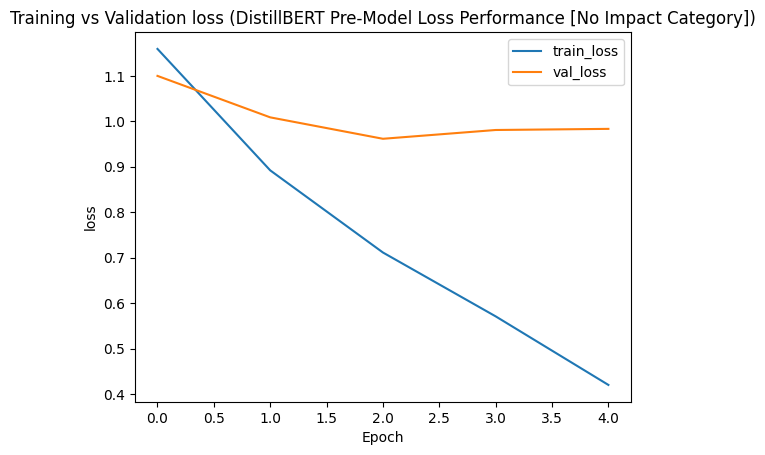

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [20]:
pre_model_loss = plot_history_loss(history_ft, title_suffix="(DistillBERT Pre-Model Loss Performance [No Impact Category])")
pre_model_loss

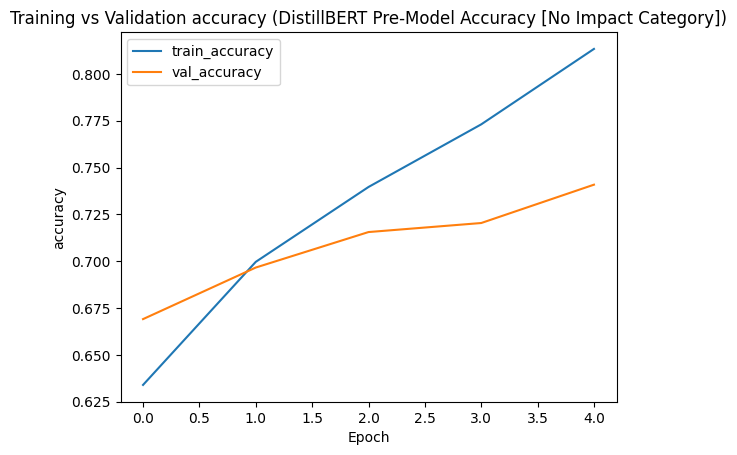

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [21]:
pre_model_accuracy = plot_history(history_ft, key="accuracy", title_suffix="(DistillBERT Pre-Model Accuracy [No Impact Category])")
pre_model_accuracy

And then let's evaluate the overall Accuracy and Macro F1 on our pre-model training round as well:

In [22]:
# Quick re-naming at the top so we can re-use this block easily later
model =  bertinator

# We'll run our predict in batches of 32 (consistent with DistillBert's training from earlier)
EVAL_BATCH = 32

logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

# Here we compile the model predictions as well to compare against the 'true' values from our test set
y_pred = np.argmax(logits_or_probs, axis=-1)
y_true = np.asarray(y_test)


# And we'll use accuracy and F-1 as Overall Model Predictors
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"\n[Experiment 9] Drop Impact Pre-Train Accuracy: {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")

# Finally, we'll print out a classification report to track the in-class
# performance.
pre_model_summary = classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
)

print(pre_model_summary)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(32,))']
  warnings.warn(msg)



[Experiment 9] Drop Impact Pre-Train Accuracy: 0.7147 | Macro F1: 0.6622

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.798     0.696     0.744      1993
      BUSINESS & MONEY      0.612     0.645     0.628       764
                COMEDY      0.539     0.551     0.545       517
                 CRIME      0.425     0.838     0.564       340
             EDUCATION      0.379     0.729     0.498       214
           ENVIRONMENT      0.561     0.695     0.621       394
FAMILY & RELATIONSHIPS      0.793     0.804     0.798      1962
          FOOD & DRINK      0.830     0.841     0.836       832
     HEALTH & WELLNESS      0.877     0.656     0.751      2591
         HOME & LIVING      0.838     0.834     0.836       416
                 MEDIA      0.352     0.815     0.492       281
            OTHER NEWS      0.533     0.482     0.506       407
              POLITICS      0.911     0.656     0.763      3272
              RELIGION      

Overall, these results are really promising, and we can compare these to the results we get with our final model in **Section 7**.

# **Section 5: Final Input Dataset Preparation**

#### **Re-Classification**

As noted in the introduction, we separated out our 'Impact' articles from the rest of our dataframe before training, and it's being stored as a DataFrame named **df_impact**. Now we will use our newly trained pre-model to re-assign these features to other categories, and then use the results to construct a final 'input' dataset for our final model. First let's prep our 'impact' dataframe for input into our newly trained model:

In [23]:
# Take the 'text' features only and create a dummy target (0's array)
# and then we'll pair that with our make_ds_bert() function from earlier.
# to prepare this for input into our model.

x_impact = df_impact["text"].astype(str).values
y_dummy_impact = np.zeros(len(x_impact), dtype='int32')

# Now make our model inputs
ds_impact_bert = make_ds_bert(x_impact, y_dummy_impact, shuffle=False)

And now let's feed that into our model to get class predictions for our 'IMPACT' article re-assignments. Note: Because BERT's pre-processing layer is finnicky, we have to pass tuple pairs of dictionary features and then our 'dummy' outputs (0's which will get re-assigned to the actual predicted category integers). Because of this structure, we can't use Keras's standard .predict() method function directly, and must instead manually iterate over the dataset here.

In [24]:
pred_ids_list = []

for xb, _ in ds_impact_bert:                            # xb is {"text": batch_of_strings}
    logits = bertinator(xb, training=False)             # pass manually into model -> extract logits
    batch_pred_ids = np.argmax(logits.numpy(), axis=-1) # take argmax to get the integer predictions
    pred_ids_list.append(batch_pred_ids)

y_pred_impact = np.concatenate(pred_ids_list, axis=0)  # Throw into an array to map back to our DF (N_impact,)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(32,))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(1,))']
  warnings.warn(msg)


Now we'll reverse-map our predicted iteger labels back onto our dataframe using our id2cat list comprehension method from earlier.

In [25]:
# Use our id2cat in a list comp to map back to string labels
pred_labels_str = [id2cat[i] for i in y_pred_impact]

# assign back to df_impact data frame
df_impact['label'] = y_pred_impact
df_impact['label_str'] = pred_labels_str

# And let's view a few as a sanity check
df_impact[['text', 'label_str']].head(5)

,text,label_str
12,"with its way of life at risk, this remote oyst...",TECH
66,monsanto and bayer are set to merge. here's wh...,BUSINESS & MONEY
125,you're going to use that self-checkout machine...,BUSINESS & MONEY
193,machines don't always steal our jobs. increasi...,TECH
286,she started a suicide prevention site at age 1...,VOICES & IDENTITY


And after checking to see if the output aligns with expectations (it did) we will append this back onto the df_no_impact. The result will be a dataframe that is the 'whole' dataset again, that we can then use to train our final model.

In [26]:
# df_impact (reclassified) + df_no_impact = new 'true' dataFrame
df_reclassified = pd.concat([df_no_impact, df_impact], ignore_index=True)

# And we'll sanity check that the IMPACT category no longer exists
# this SHOULD be empty
df_reclassified[df_reclassified['label_str'].str.contains("IMPACT")].head(5)

,text,label_str,authors,link,date,label


Great, now we can just run everything in our pipeline that is downstream of this point to train our new final model. To keep things standardized, we will train both our pre-model (using the partial features) and the final model (using our newly augmented dataset) using the same methodology, and then both models will be evaluated in **Section 6**. Let's begin by using our sanity checks from before again on our new-and-improved input data to make sure our efforts are still grounded in reality.

In [27]:
print(f"Unique labels (after consolidation): {len(df_reclassified["label_str"].unique())}\n")
print(df_reclassified["label_str"].value_counts().head(25))

# And quick double check that we got all of the empty rows
print("\n Any empty texts left? ", (df_reclassified["text"].str.len()==0).sum())

Unique labels (after consolidation): 22

label_str
POLITICS                  32890
HEALTH & WELLNESS         26270
ARTS & ENTERTAINMENT      19993
FAMILY & RELATIONSHIPS    19887
VOICES & IDENTITY         15688
TRAVEL                     9963
STYLE & BEAUTY             9526
WORLD NEWS                 8922
FOOD & DRINK               8350
BUSINESS & MONEY           8032
COMEDY                     5185
SPORTS                     4956
HOME & LIVING              4179
OTHER NEWS                 4178
ENVIRONMENT                4148
CRIME                      3539
MEDIA                      2877
RELIGION                   2685
EDUCATION                  2428
STYLE                      2263
SCIENCE                    2230
TECH                       2167
Name: count, dtype: int64

 Any empty texts left?  0


Because this new df_reclassified dataset has passed all of our tests, at this point we will re-assign our augmented data to the variable name 'df' and then re-run our pipeline from earlier. First, re-assignment:

In [28]:
df = df_reclassified

And now, we will re-run the pipeline from this point, re-naming the model and the history objects to avoid re-training issues and to compare our results from **Section 3** and **Section 5**. First, we'll re-run our class integer list comprehensions on the newly-compiled dataframe using our same methods from earlier.

In [29]:
cats = sorted(df["label_str"].unique())

# Encode Categories
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

Now, re-tokenization:

In [30]:
# First Tokenize, and then get a feel for the counts
token_counts = df["text"].str.split().apply(len)

# Originally used to get the 95th percentile to impose a hard cap on tokens
# but changed to 128 hard cap in Experiment 8 - Details in Appendix A
p95 = int(np.percentile(token_counts, 95))
MAX_LENGTH = 128

print(f"Classes: {len(cats)} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))

Classes: 22 | p95=56 → MAX_LENGTH=128
label_str
POLITICS                  32890
HEALTH & WELLNESS         26270
ARTS & ENTERTAINMENT      19993
FAMILY & RELATIONSHIPS    19887
VOICES & IDENTITY         15688
TRAVEL                     9963
STYLE & BEAUTY             9526
WORLD NEWS                 8922
FOOD & DRINK               8350
BUSINESS & MONEY           8032
Name: count, dtype: int64


And now, we will re-split our data with our augmented categories:

In [31]:
# Stratified 80/10/10 splits

# filter DF to just our features and target
X = df["text"].values
y = df["label"].values

# Train vs temp (later split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Split the Temp into Val and Test 50/50
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")

Train/Val/Test sizes: 160284 / 20036 / 20036


And re-compute our class weights as the re-assignment has changed the relative class balances.

In [32]:
classes = np.arange(len(cats))

# Apply SKlearn's balanced class weights
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]



# The output is our integer labels from cat2id, and then a class weight
# to help with classification

[(0, 0.4555230938874805),
 (1, 1.133774722010016),
 (2, 1.7564214955728938),
 (3, 2.5735204392922513),
 (4, 3.7516150173204754),
 (5, 2.19579155022193),
 (6, 0.45792811839323466),
 (7, 1.090664126292869),
 (8, 0.3466709346991037),
 (9, 2.179370733962418)]

And now we will re-prepare it for intake into BERT's pre-processing layer.

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32

# apply function to our training and validation splits
ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)
ds_test_bert = make_ds_bert(X_test, y_test, shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


# **A.2 Model Selection and Re-training**

Now that our final Impact re-classified dataset has been obtained, we are clear to move on to using this dataset as an input to train our final model. As a brief review, this final model was the DistillBERT Classifier with a custom classification head of the following structure:

- 1024 Dense Neuron (ReLu) Activation Layer
  - 0.3 Dropout
- 524 Dense Neuron (ReLu) Activation Layer
  - 0.3 Dropout
- 256 Dense Neuron (ReLu) Activation Layer
  - 0.3 Dropout

As a training regimine, we have gone with a two phased approach whereby we will first freeze the Distill-BERT backbone and train our custom classification head for 3 epochs (adam optimizer, with a high LR: 1e-3). The we will un-freeze the BERT backbone and train for a maximum of 6 more epochs at a lower 2e-5 Learning Rate. This second round of training will be with both early stopping as well as a reduce LR on plateau callbacks to prevent any overfitting. As articulated earlier, our thought process as to *why* these decisions were made is detailed in Appendix A.

## **Section 6: Final Model Training**

#### **Modeling with Augmented Categories**

Here we will run our pipeline using the same architecture as before, only this time, we will run it with our augmented categories. The only meaningful difference here will be the re-naming of the model itself so that we do not re-train the pre-model from earlier.

In [34]:
# Quick Pulls from Earlier

NUM_CLASSES = len(cats) # Number of Categories post Cleaning
MAX_LEN     = MAX_LENGTH # Hard Cap on token length


# Distill BERT Pipeline
preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)


# Model Inputs
text_in  = keras.Input(shape=(), dtype="string", name="text") # Input Raw Strings of our MAX_LENGTH set from earlier
tokens   = preproc(text_in)

backbone = pipeline.get_layer("distil_bert_backbone")
backbone.trainable = True    # Again, we'll change this later

seq_out  = backbone(tokens)       # Bert output (B, T, 768)

# Bypass Bert's Classification Layer and use our own head instead -- again
cls    = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)

# Our (same) Custom Classification Head
x      = layers.Dense(1028, activation="relu")(cls)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(512, activation="relu")(x)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(256, activation="relu")(x)

logits = layers.Dense(NUM_CLASSES, activation=None, name="logits")(x)

# Name it to call for summary later
son_of_bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

# And summarize
son_of_bertinator.summary()

Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 128),     │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 128, 768)  │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1028)      │    790,532 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 1028)      │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    526,848 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 512)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 22)        │      5,654 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,817,242 (258.70 MB)

 Trainable params: 67,817,242 (258.70 MB)

 Non-trainable params: 0 (0.00 B)

And now, we will implement the same multi-tiered training strategy we implemented before. To review:
- Step 1: Freeze the backbone - Train the classification head
- Step 2: Un-Freeze the backbone - Train the Underlying Transformer

In [35]:
# Compile the Bert Backbone - This time, we compile it as frozen with a high LR
backbone.trainable = False                                           # frozen again


# And make sure we compile the NEW model
son_of_bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),             # High LR this time (for the head)
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)


# Start Training Timer
start = time.time()

# We'll hard cap the epochs at 3 this time (and will train more later)
EPOCHS = 3

# We'll also use Early Stopping as a failsafe to prevent overfitting
# (even though that's not expected with only 3 epochs this round)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


pre_history = son_of_bertinator.fit(      # < - Changing the model name here to the new value
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,       # Use our class weights from Earlier
    callbacks=cb,                     # Only early stopping as it's a warm up
    verbose=2,                        # Setting verbose to 2 to cut down on Colab log spam
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)


5009/5009 - 111s - 22ms/step - accuracy: 0.4747 - loss: 1.6806 - val_accuracy: 0.5625 - val_loss: 1.4828
Epoch 2/3
5009/5009 - 101s - 20ms/step - accuracy: 0.5309 - loss: 1.5010 - val_accuracy: 0.5741 - val_loss: 1.4073
Epoch 3/3
5009/5009 - 101s - 20ms/step - accuracy: 0.5381 - loss: 1.4622 - val_accuracy: 0.5924 - val_loss: 1.3424
Elapsed Time: 5.22 min


And from here, we will implement the same structure for the second round of training, where we un-freeze the backbone and train the underlying transformer.

In [36]:
# Re-Compile wiht an unfrozen backbone this time
backbone.trainable = True


# Again we need to re-compile it with an un-frozen backbone this time
son_of_bertinator.compile(
    optimizer=keras.optimizers.Adam(2e-5), # lower starting LR this time to prevent overfitting
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=False
)

# And fit a second (or 4th? technically?) time
start = time.time()

# Bumped the max up to 6 epochs this round
EPOCHS = 6

# Callbacks - Same early stopping as before but with Reduce on Pleateau this time
# (as an extra fail safe)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

# Same overall as before, just wiht a list of callbacks this time
new_history_ft = son_of_bertinator.fit(                           # And we'll make sure to re-name our 'new' history object as well
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 362s 68ms/step - accuracy: 0.6057 - loss: 1.2490 - val_accuracy: 0.6805 - val_loss: 1.0364 - learning_rate: 2.0000e-05
Epoch 2/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 341s 68ms/step - accuracy: 0.6841 - loss: 0.9380 - val_accuracy: 0.6943 - val_loss: 1.0143 - learning_rate: 2.0000e-05
Epoch 3/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 339s 68ms/step - accuracy: 0.7294 - loss: 0.7435 - val_accuracy: 0.7025 - val_loss: 0.9936 - learning_rate: 2.0000e-05
Epoch 4/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 340s 68ms/step - accuracy: 0.7621 - loss: 0.5973 - val_accuracy: 0.7153 - val_loss: 0.9828 - learning_rate: 2.0000e-05
Epoch 5/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7942 - loss: 0.4849
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 338s 68ms/step - accuracy: 0.7942 - loss: 0.4849 - val_accuracy: 0.7200 - val_loss: 1.0074 - learning_rate: 2.0000e-05
Epoch 6/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 0s 66

___

And now that everything is trained, we can move on to our final model results.



# **A.3 Evaluation and Visualization**

As a brief overview, for our evaluation strategy, we have been using both overall accuracy as well as in class recall to evaluate model performance both overall as well as tracking in-class performance of specific class labels. As detailed in Appendix A, we have been using a combination of in-class recall and precision to track how well our model is doing at predicting a certain category, as well as if our model is mistaking other categories as belonging to a certain class. If certain classes were under-performing, we investigated data mitigation strategies to try to improve that class's performance as well as well as our Macro F1 score overall.

# **Section 7: Results and Discussion**

#### **Results: Final Model Performance Plots**

First, let's investigate the results of our final model based on the re-classified data. First, we'll investigate the validation loss ussing the same function from earlier.



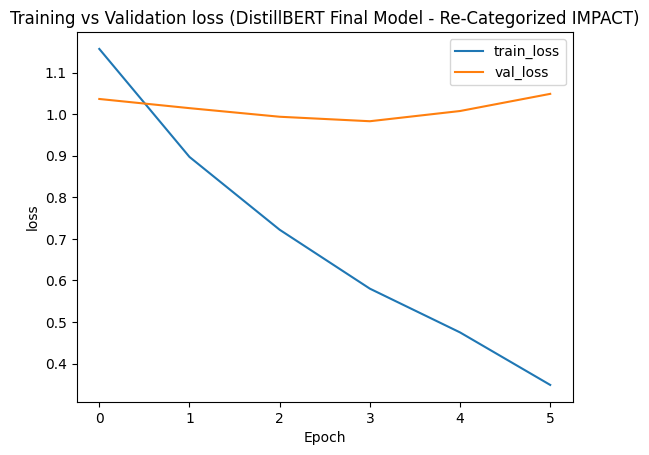

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [37]:
final_model_loss = plot_history_loss(new_history_ft, title_suffix="(DistillBERT Final Model - Re-Categorized IMPACT)")
final_model_loss

And next, we'll investigate how our final model did in terms of accuracy, again using the same function as before.

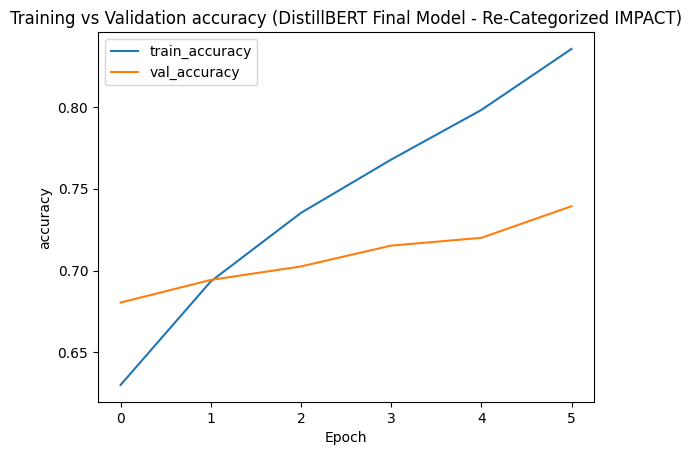

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

In [38]:
final_model_accuracy = plot_history(new_history_ft, key="accuracy", title_suffix="(DistillBERT Final Model - Re-Categorized IMPACT)")
final_model_accuracy

Now, let's investigate the test set performance and print out a final classification report to investigate our *in-class* performance on this model as well. Here we will run the same code as we did with the pre-model earlier,

In [47]:
# Changing the name at the top to reflect our final model nomenclature
model =  son_of_bertinator

# We don't need to name this again, but we found it easier to keep track
EVAL_BATCH = 32


logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

# Here we compile the model predictions to compare against the 'true' values
y_pred = np.argmax(logits_or_probs, axis=-1)
y_true = np.asarray(y_test)

# Calculate overall accuracy and F1 stats
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

# Throw it in a classification report that we can print later
final_classification_report = classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
)

# And finally, we'll make a confusion matrix this time as well
final_confusion_matrix = confusion_matrix(y_true, y_pred)


Here, we'll print our results for the Overall Accuracy, F1 Score, and our classification report:

In [69]:
print(f"\nDistillBERT Final Model - Re-Categorized IMPACT: Overall Accuracy {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")
print(final_classification_report)


DistillBERT Final Model - Re-Categorized IMPACT: Overall Accuracy 0.7178 | Macro F1: 0.6714

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.768     0.705     0.736      1999
      BUSINESS & MONEY      0.607     0.641     0.624       803
                COMEDY      0.497     0.672     0.571       518
                 CRIME      0.483     0.780     0.596       354
             EDUCATION      0.404     0.716     0.516       243
           ENVIRONMENT      0.530     0.677     0.595       415
FAMILY & RELATIONSHIPS      0.804     0.800     0.802      1989
          FOOD & DRINK      0.815     0.863     0.838       835
     HEALTH & WELLNESS      0.876     0.708     0.783      2627
         HOME & LIVING      0.829     0.856     0.842       418
                 MEDIA      0.433     0.712     0.539       288
            OTHER NEWS      0.476     0.620     0.538       418
              POLITICS      0.932     0.600     0.730      3289
         

And this is consistent with waht we've been finding in our experiments in Appendix A, with overall high recall across categories, except in our Voices & Identity category, and some other hiccups in 'Politics' and 'Other News'. However, this marks a significant improvement in in-class model performance  since the beginning of Milestone 2 overall. Next we'll print the confusion matrix.

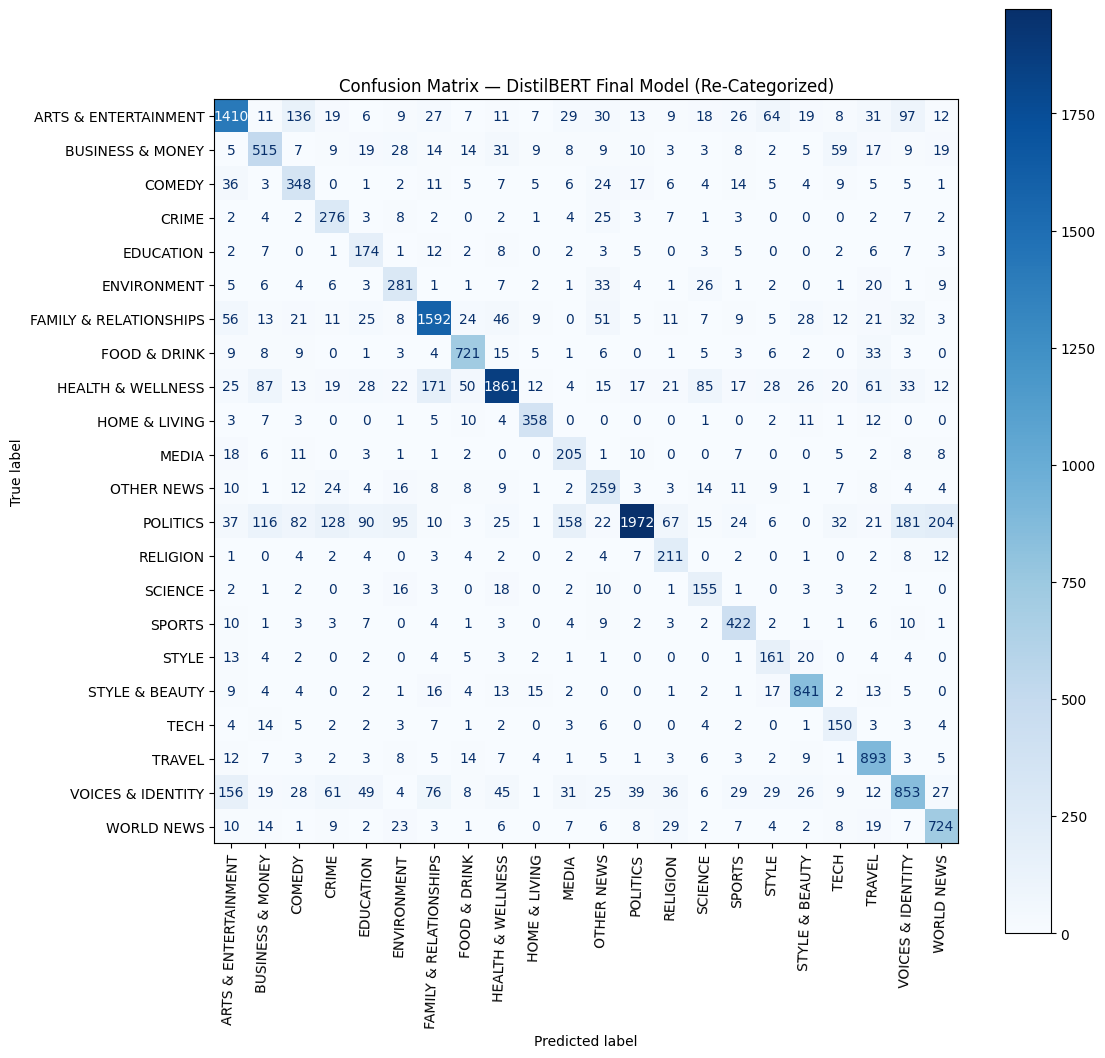

In [64]:
# First we'll get the labels and their text representations
labels = list(range(NUM_CLASSES))
display_labels = [id2cat[i] for i in labels]

# And then we will create the confusion matrix plot.
fig, ax = plt.subplots(figsize=(12, 12))

disp = ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    labels=labels,
    display_labels=display_labels,
    xticks_rotation=88,
    cmap="Blues",
    ax=ax
)

ax.tick_params(axis='x', labelsize=10)
plt.title("Confusion Matrix — DistilBERT Final Model (Re-Categorized)")
plt.show()

And here we can see that the model did very well overall, with some notable exceptions in the Voices & Identity category and the Politics category again. Specifically, there are a number of 'Voices and Identity' articles that were misclassified as 'Arts & Entertainment', which could be investigated in future research. Additionally, a number of 'politics' pieces were misclassified in a variety of other subjects, including: Media, Business & Money, Crime, Voices & Identity, and World News, which also provides a future direction that we could take in improving model performance.

#### **Discussion**

In terms of getting the 'best performing model' with all of the original data from the dataset intact, our **final model** was the best overall performer, often achieving just over **72% overall accuracy** across model runs and slightly edging out our other models. Additionally, this model came with the benefit of having a pipeline to automatically resolve inconsistencies caused by outsourced or potentially deprecated editorial categories as well.To elaborate, a number of the categories in our HuffPost Dataset are no longer used on the present-day website (Impact, Weird News, Comedy, Education, and Style are all examples). So if we were performing this task for a Data Science team at HuffPost, (or any other company), a likely reason *why* we would be given this assignment would be as part of a data migration and re-labeling event. Additionally, our stakeholders would not want the model to predict categories that no longer exist in production. In this sense, if there were any categories that were deprecated in the future, (and our team didn't have a 1:1 mapping for how we would re-assign these categories), our model pipeline could easily be configured to the new 'production' label configuration, by using the same process that we did with the 'Impact' category. This would make it not only the top performing model overall, but also a useful model to have in the future as well.



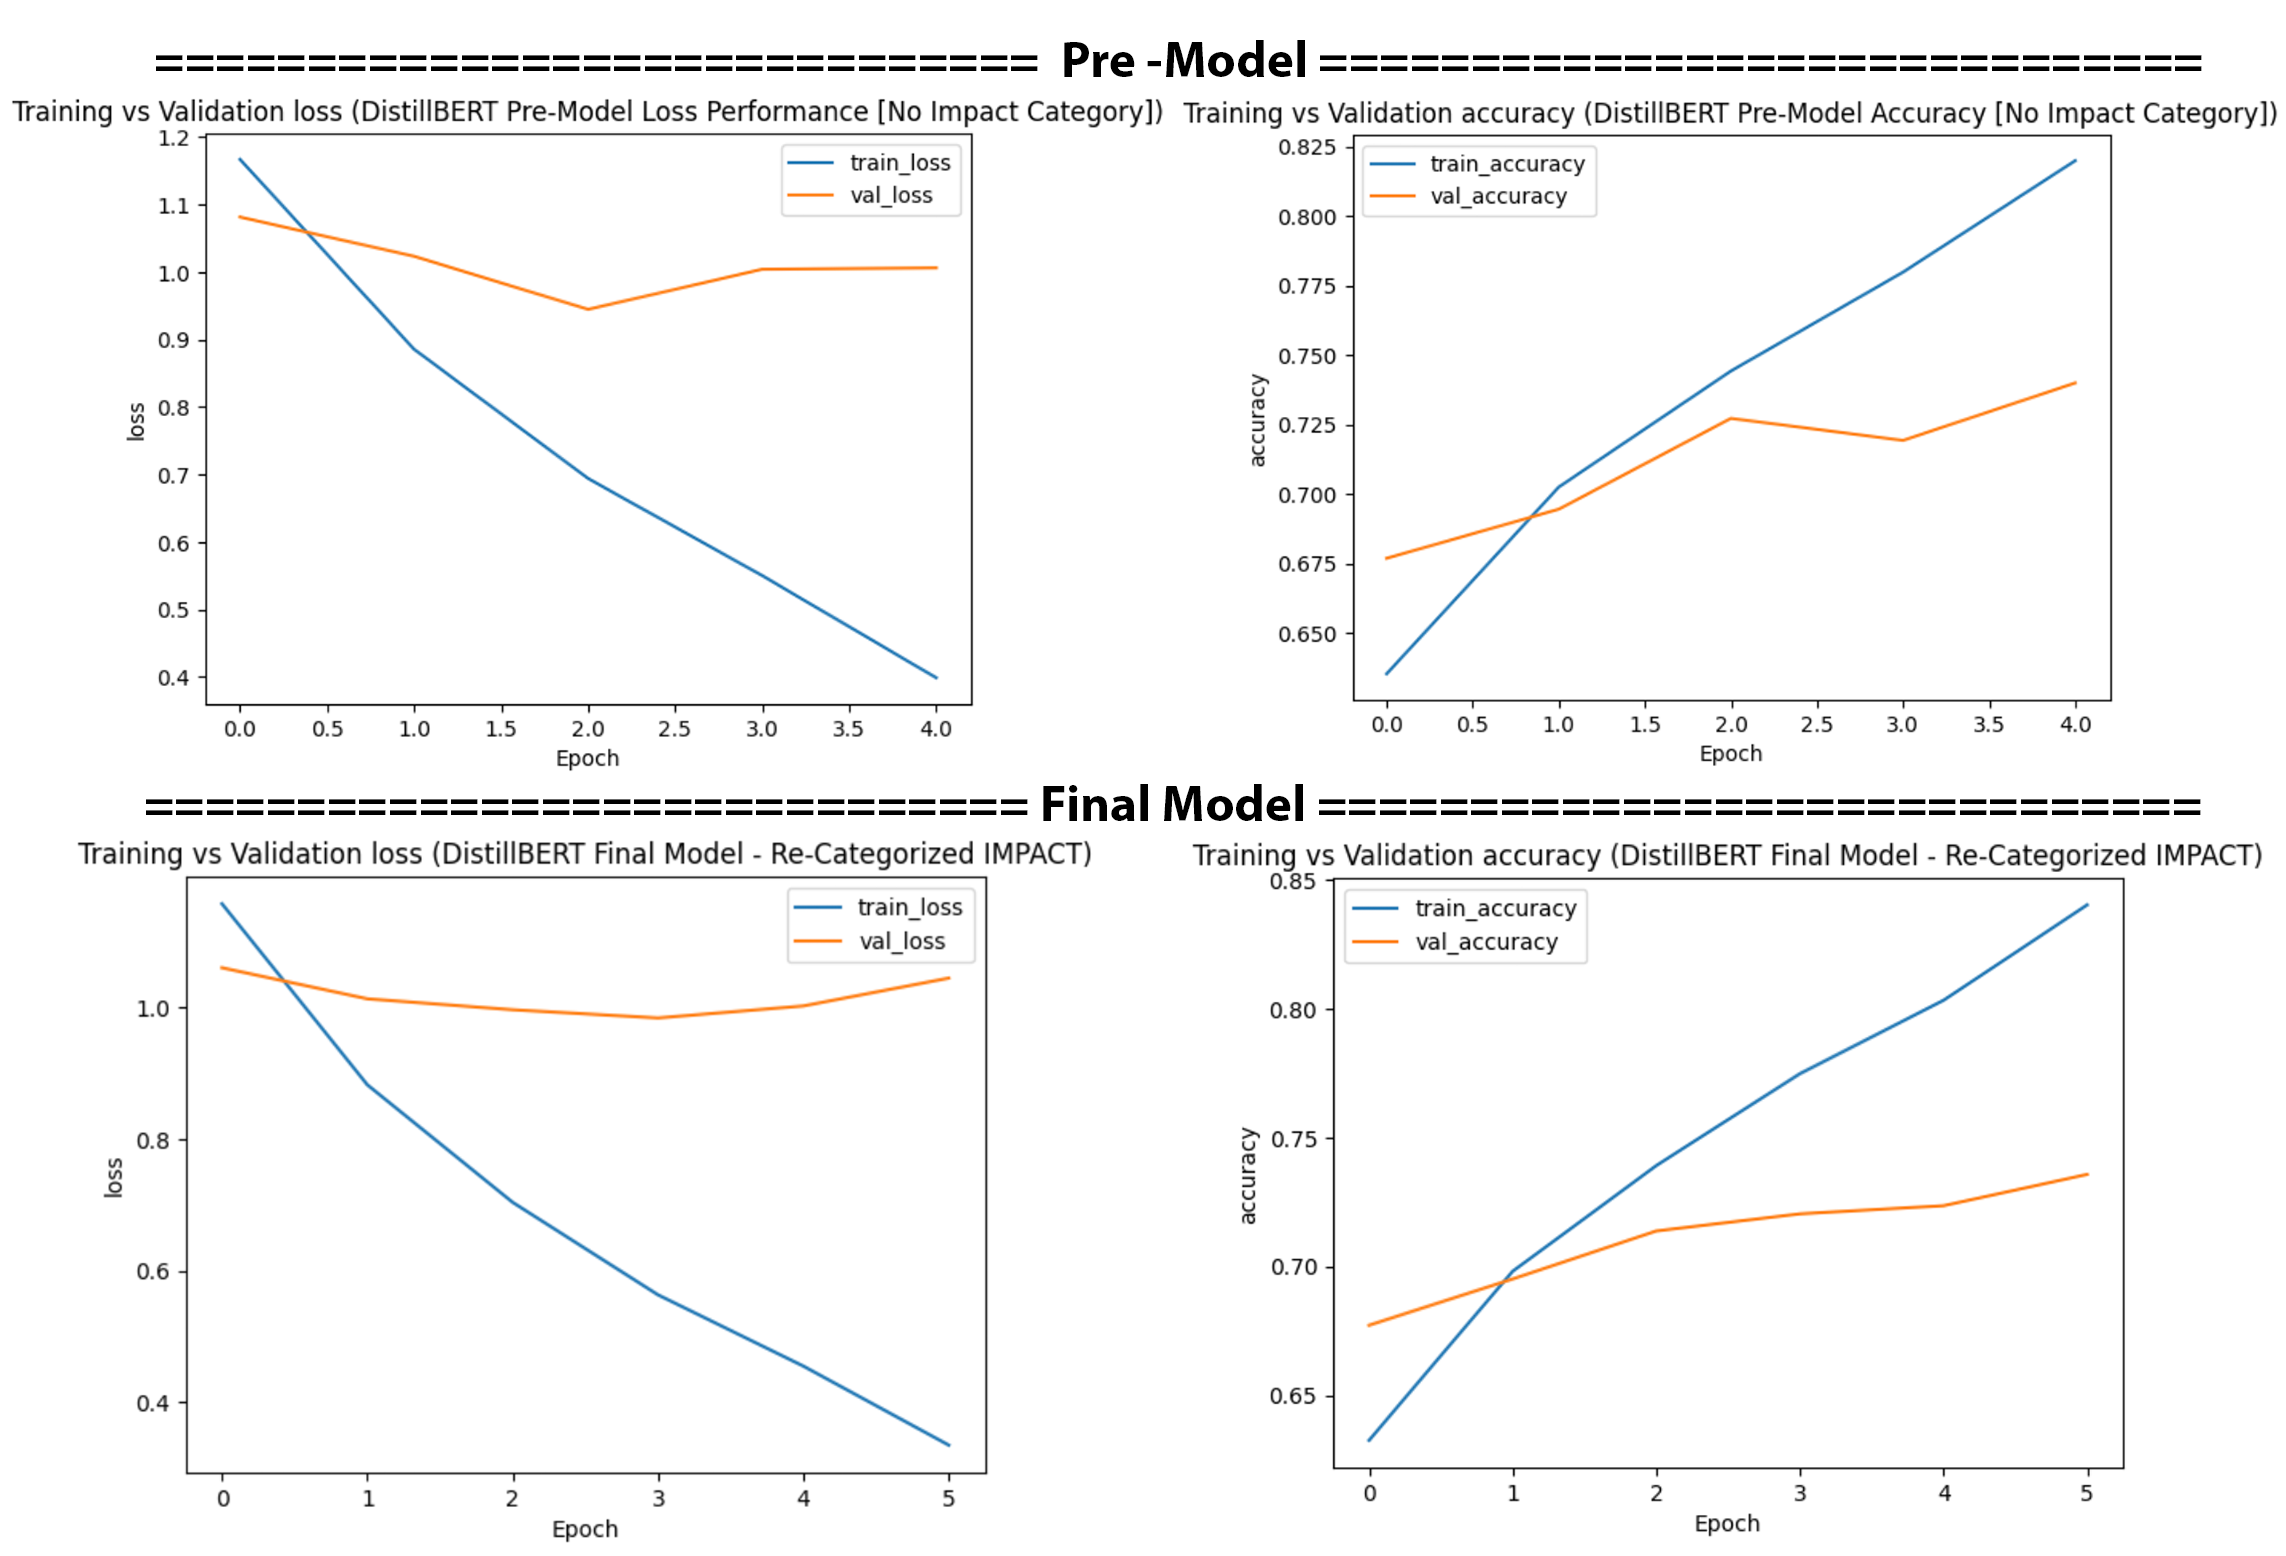

As discussed in the results section, our model still struggled with a few categories, (namely the Voices & Identity, and Politics categories) and in order to improve our model performance, there are a number of strategies that we could take in the future, to be discussed in **Section 8**.

_____

# **Section 8: Future Research Directions**

As discussed previously, the number one priority we would discuss with stakeholders would be if categories like 'IMPACT' that were outsourced or deprecated should be re-assigned or dropped entirely. To elaborate, we recieved quite the surprise when just dropping the 'Impact' category resulted in a significant boost in model performance, and even achieved an overall accuracy of ~77% in one of our model runs (though most runs hovered around the 72% accuracy range).

**Best Model Run: Pre-Model [Trained on Dataset missing the IMPACT Category]**

- **Overall Accuracy: 0.7701 | Macro F1: 0.7434**

| Category                 | Precision | Recall | F1-Score | Support |
|--------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT     | 0.848     | 0.681  | 0.755    | 2000    |
| BUSINESS & MONEY         | 0.683     | 0.696  | 0.690    | 807     |
| COMEDY                   | 0.540     | 0.671  | 0.598    | 519     |
| CRIME                    | 0.600     | 0.888  | 0.716    | 347     |
| EDUCATION                | 0.490     | 0.887  | 0.631    | 240     |
| ENVIRONMENT              | 0.638     | 0.856  | 0.731    | 418     |
| FAMILY & RELATIONSHIPS   | 0.859     | 0.799  | 0.828    | 1982    |
| FOOD & DRINK             | 0.843     | 0.926  | 0.883    | 837     |
| HEALTH & WELLNESS        | 0.893     | 0.729  | 0.803    | 2641    |
| HOME & LIVING            | 0.801     | 0.952  | 0.870    | 419     |
| MEDIA                    | 0.495     | 0.870  | 0.631    | 284     |
| OTHER NEWS               | 0.648     | 0.761  | 0.700    | 422     |
| POLITICS                 | 0.920     | 0.680  | 0.782    | 3291    |
| RELIGION                 | 0.631     | 0.918  | 0.748    | 268     |
| SCIENCE                  | 0.531     | 0.929  | 0.675    | 224     |
| SPORTS                   | 0.707     | 0.944  | 0.808    | 496     |
| STYLE                    | 0.466     | 0.934  | 0.622    | 227     |
| STYLE & BEAUTY           | 0.913     | 0.878  | 0.895    | 952     |
| TECH                     | 0.480     | 0.953  | 0.638    | 214     |
| TRAVEL                   | 0.872     | 0.917  | 0.894    | 997     |

At this point, (corroborated by our research into the "IMPACT" category in Appendix A), it would be worth having the discussion with our stakeholders / managers if it would be alright to drop this category in order to get the 'best performing model possible'. Our reasoning behind this decision (to just drop the 'impact category altogether) would be:

- It only represents ~1.5% fo the dataset
- It was an outsourced category that was never written by 'HuffPost' staff.
- It never covered a consistent 'category' but rather whatever the owners of this third party company wanted to draw attention to.
- Dropping it technically resulted in our 'best' performing model overall.

So, if this was considered a *legal* move to make by our stakeholders, it could represent a significant new direction in our analysis. 

Additionally, in terms of future directions we could go as far as research is concerned and as discussed in **Section 7**, our model seemed to struggle with classification in both the 'voices and identity' section and the 'politics' section. In terms of the voices and identity section, we could investigate
the interconnection between this section and the Arts & Entertainment section, to better get a handle on *why* the model was mis-predicting these articles. A possible strategy with this could involve seperating out our 'Voices and Identity' category into its constituent parts (Women, Black Voices, Latino Voics, and Queer Voices) to see if the confusion was coming from any one of these groupd in particular. Additionally, the Politics category remains another challenge. As this category is amorphous and could cover a wide array of issues, it makes total sense that the model is getting confused. In this case, we could implement a data augmentation procedure with our Politics category like back translation, or generating 'political' data for each of these sub-categories (minority politics, world politics, etc.) to see if this helped the model distiguish between the two.

Overall, these represent great directions we could take in future research into model performance.

___

# **Appendix A**
### **Methodology and Experimental Discussion**

Here we discuss why decisions were made in each section, from pre-processing and label consolidation; to architecture and training regimine choices; as well as a detailed look at experimental findings post milestone 2. Although it is a bit counter-intuitive from a flow perspective, we will start with model architecture choices and then work our way backwards to pre-processing and label consolidation. This is mainly to reflect the order in which decisions were made, as we started with architecture choices, and once we ran into stubborn overall accuracy ceilings along with persistantly low in-class recall, we moved towards more invasive data remediations to improve prediction accuracy.

#### **Model Architecture and Methodologies**

**Milestone 2 Progress so Far**



In milestone 2, we had tried 3 different pre-trained transformer model iterations: BertBASE, Distil-BERT, and Distil-Bert + a Custom head. All three of the models had Test Accuracies around 68% with the formal rankings being:

- BertBASE:                  68.93% Test Accuracy
- Distil-BERT:               68.71% Test Accuracy
- Distil-Bert + Custom Head: 68.56% Test Accuracy

We chose to go with the DistilBERT + Custom Head as it was negligibly under the other two in performance, it gave us the best amount of personalization options for our dataset, and it was much quicker to train than using the BertBASE model (often training 33% faster). Our 'base' model architecture was extremely light in this regard, a single dense layer of 256 neurons + a single layer of dropout (0.3). This gave us a good base to work off of, and the first experiment we tried was to 'beef up' this base custom head to have both more layers in general as well as wider layers.

**Experiment 1: Wider Layers + Deeper Architecture**

In experiment 1, we went from 1 dense 256 neuron layer + dropout on the classification head to the following architecture. To note, at this point we were still only training on one training round with a 4 epoch hard cap.

- 1028 Neurons (ReLu)
 - Dropout (0.3)
- 526 Neurons (ReLu)
- Dropout (0.3)
- 256 Neurons (ReLu)

And the results were only imroved to: **Accuracy: 0.6884 | Macro F1: 0.6130**. This was a little dissapointing as a first round, as we only improved 00.32% (practically negligible) on overall accuracy. Here we determined that it was best to split the training into two rounds (one with a frozen backbone, one without) in order to assess if the plateau in accuracy was due to vanishing gradients.

**Experiment 1: Results**

 - **Accuracy: 0.6884 | Macro F1: 0.6130**

| Category                | Precision | Recall | F1-Score | # of Records |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.839     | 0.617  | 0.711    | 1993    |
| BLACK VOICES            | 0.479     | 0.633  | 0.545    | 452     |
| BUSINESS & MONEY        | 0.614     | 0.661  | 0.636    | 764     |
| COMEDY                  | 0.497     | 0.558  | 0.526    | 516     |
| CRIME                   | 0.550     | 0.709  | 0.620    | 340     |
| EDUCATION               | 0.449     | 0.716  | 0.552    | 215     |
| ENVIRONMENT             | 0.478     | 0.728  | 0.577    | 394     |
| FAMILY & RELATIONSHIPS  | 0.859     | 0.750  | 0.801    | 1962    |
| FIFTY                   | 0.203     | 0.657  | 0.310    | 140     |
| FOOD & DRINK            | 0.828     | 0.853  | 0.840    | 832     |
| GOOD NEWS               | 0.359     | 0.364  | 0.362    | 140     |
| HEALTH & WELLNESS       | 0.883     | 0.654  | 0.751    | 2451    |
| HOME & LIVING           | 0.714     | 0.858  | 0.779    | 416     |
| IMPACT                  | 0.333     | 0.520  | 0.406    | 346     |
| LATINO VOICES           | 0.359     | 0.779  | 0.492    | 113     |
| MEDIA                   | 0.452     | 0.683  | 0.544    | 281     |
| POLITICS                | 0.924     | 0.599  | 0.727    | 3272    |
| QUEER VOICES            | 0.743     | 0.751  | 0.747    | 631     |
| RELIGION                | 0.509     | 0.678  | 0.582    | 255     |
| SCIENCE                 | 0.514     | 0.674  | 0.583    | 218     |
| SPORTS                  | 0.735     | 0.781  | 0.757    | 489     |
| STYLE                   | 0.457     | 0.728  | 0.561    | 224     |
| STYLE & BEAUTY          | 0.875     | 0.855  | 0.865    | 951     |
| TECH                    | 0.386     | 0.631  | 0.479    | 203     |
| TRAVEL                  | 0.852     | 0.828  | 0.840    | 989     |
| WEIRD NEWS              | 0.504     | 0.434  | 0.467    | 267     |
| WOMEN                   | 0.277     | 0.618  | 0.383    | 340     |
| WORLD NEWS              | 0.657     | 0.800  | 0.722    | 842     |

**Experiment 2: Two Training Rounds**

As detailed earlier, here we split the training into two rounds. First we trained the classification head alone (by freezing the backbone) for a quick 3 epochs, and then we unfroze the Bert backbone and trained for another 4 epochs (with early stopping) again to ameliorate any vanishhing gradient effects. Our results were: **Accuracy: 0.6803 | Macro F1: 0.6063**, which reflected a slight dip in performance, though the model trained for all 4 epochs (and was not stopped by early stopping), and from the validation curves looking like we had not yet reached a plateau,  we reasoned that we might still be underfitting the data.

**Experiment 2 Final Results**

- **Accuracy: 0.6803 | Macro F1: 0.6063**

|Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.826     | 0.599  | 0.694    | 1993    |
| BLACK VOICES            | 0.518     | 0.575  | 0.545    | 452     |
| BUSINESS & MONEY        | 0.602     | 0.671  | 0.635    | 764     |
| COMEDY                  | 0.451     | 0.581  | 0.508    | 516     |
| CRIME                   | 0.532     | 0.709  | 0.608    | 340     |
| EDUCATION               | 0.452     | 0.698  | 0.548    | 215     |
| ENVIRONMENT             | 0.522     | 0.718  | 0.605    | 394     |
| FAMILY & RELATIONSHIPS  | 0.863     | 0.727  | 0.789    | 1962    |
| FIFTY                   | 0.147     | 0.664  | 0.241    | 140     |
| FOOD & DRINK            | 0.785     | 0.873  | 0.826    | 832     |
| GOOD NEWS               | 0.263     | 0.529  | 0.352    | 140     |
| HEALTH & WELLNESS       | 0.884     | 0.637  | 0.741    | 2451    |
| HOME & LIVING           | 0.626     | 0.861  | 0.725    | 416     |
| IMPACT                  | 0.389     | 0.379  | 0.384    | 346     |
| LATINO VOICES           | 0.378     | 0.752  | 0.503    | 113     |
| MEDIA                   | 0.410     | 0.719  | 0.522    | 281     |
| POLITICS                | 0.933     | 0.598  | 0.729    | 3272    |
| QUEER VOICES            | 0.749     | 0.753  | 0.751    | 631     |
| RELIGION                | 0.510     | 0.710  | 0.593    | 255     |
| SCIENCE                 | 0.472     | 0.734  | 0.575    | 218     |
| SPORTS                  | 0.729     | 0.775  | 0.751    | 489     |
| STYLE                   | 0.398     | 0.714  | 0.511    | 224     |
| STYLE & BEAUTY          | 0.848     | 0.838  | 0.843    | 951     |
| TECH                    | 0.480     | 0.640  | 0.549    | 203     |
| TRAVEL                  | 0.837     | 0.844  | 0.840    | 989     |
| WEIRD NEWS              | 0.435     | 0.536  | 0.480    | 267     |
| WOMEN                   | 0.308     | 0.544  | 0.394    | 340     |
| WORLD NEWS              | 0.722     | 0.752  | 0.736    | 842     |

**Experiment 3: More Data + More Epochs + Reduce on Pleateau Introduction**

After we reasoned that we might still be underfitting the data in Experiment 2, we figured we would increase the amount of epochs that the model was allowed to train on from 4 to 6 (in the second training round). Of course, a possible drawback to this might be overfitting, so we also added in Reduce Learning Rate on Plateau as another callback (in addition to the early stopping that had been implemented previously). The idea here was to put checks and balances in place, and then allow the model to train to a point where it stopped itself instead of us arbitrarily imposing a training cap on it.

Additionally, we noticed that there were a number of category labels that were under-represented (Good News for example, only had 140 records in the training set), that were performing poorly compared to their peers. To counter the fact that this might be due to underrepresentation, we increased the relative percentage of the dataset that the model was trained on from 25% to 50% (roughly doubling it in each category). We figured this would allow us to keep experimenting while still keeping a handle on computational costs. Our results were **Accuracy: 0.6848 | Macro F1: 0.6124** which was again hitting the same relative plateau in performance that we had met earlier. At this point, some categories were achieving in-class recall over 80% (like Food and Drink), while others like Good News, Weird News, and Impact, were only getting ~0.45.

It was then that we figured a more direct approach to addressing these specific class differences **in the datasets themselves** would be more beneficial than trying to implement further architectural changes.

**Experiment 3 Final Results**

- **Accuracy: 0.6848 | Macro F1: 0.6124**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.838     | 0.630  | 0.719    | 1993    |
| BLACK VOICES            | 0.479     | 0.648  | 0.551    | 452     |
| BUSINESS & MONEY        | 0.588     | 0.677  | 0.629    | 764     |
| COMEDY                  | 0.461     | 0.587  | 0.517    | 516     |
| CRIME                   | 0.536     | 0.738  | 0.621    | 340     |
| EDUCATION               | 0.405     | 0.730  | 0.521    | 215     |
| ENVIRONMENT             | 0.536     | 0.703  | 0.608    | 394     |
| FAMILY & RELATIONSHIPS  | 0.858     | 0.720  | 0.783    | 1962    |
| FIFTY                   | 0.165     | 0.671  | 0.265    | 140     |
| FOOD & DRINK            | 0.845     | 0.845  | 0.845    | 832     |
| GOOD NEWS               | 0.344     | 0.443  | 0.388    | 140     |
| HEALTH & WELLNESS       | 0.874     | 0.656  | 0.750    | 2451    |
| HOME & LIVING           | 0.747     | 0.822  | 0.783    | 416     |
| IMPACT                  | 0.401     | 0.431  | 0.415    | 346     |
| LATINO VOICES           | 0.340     | 0.770  | 0.472    | 113     |
| MEDIA                   | 0.435     | 0.712  | 0.540    | 281     |
| POLITICS                | 0.932     | 0.587  | 0.720    | 3272    |
| QUEER VOICES            | 0.729     | 0.764  | 0.746    | 631     |
| RELIGION                | 0.493     | 0.714  | 0.583    | 255     |
| SCIENCE                 | 0.455     | 0.739  | 0.563    | 218     |
| SPORTS                  | 0.703     | 0.824  | 0.759    | 489     |
| STYLE                   | 0.479     | 0.674  | 0.560    | 224     |
| STYLE & BEAUTY          | 0.857     | 0.840  | 0.849    | 951     |
| TECH                    | 0.444     | 0.685  | 0.539    | 203     |
| TRAVEL                  | 0.855     | 0.815  | 0.834    | 989     |
| WEIRD NEWS              | 0.500     | 0.472  | 0.486    | 267     |
| WOMEN                   | 0.282     | 0.576  | 0.378    | 340     |
| WORLD NEWS              | 0.688     | 0.765  | 0.724    | 842     |
                        

#### **Pre-Processing and Label Consolidation Choices**

**Experiment 4: Further Label Consolidation + Architecture Changes from Exp.3**

In Milestone 1, we evaluated categories for *lexical* similarity using a Jaccard Similarity analysis. In this, we found categories (like Art vs. Arts & Culture vs. Culture & Arts) that we could broadly consolidate, but we stopped short of consolidating any classes that did not obviously belong to the same group. In this experiment, we looked at the semantic similarity by investigating the subject matter of the articles as well as how things were grouped on the HuffPost Website to get a better feel for if our underperforming catefories were actually part of a much larger class.

The first up on the docket was 'good news' and 'weird news' which were both under-represented (only 140 and 280 records in trainingset each), under performing (~40-49% in recall consistantly), and didn't have a high lexical overlap with many other categories. Here we revisited them and fond that they had a jaccard overlap score *with each other* of 0.49 (which is a higher lexical overlap than Arts & Culture and Culture & Arts had). Because both seemed like 'other' categories anyways, we investigated consolidating them in the hopes that this would give more 'group representation'. The result of this experiment was a moderate success. (The recall of the resulting group after model training this round was ~ 56% which marked a 7-15% bump in performance over the initial categories). Next, the category 'Fifty' was added to the "Health & Wellness" category, as this was another under-represented group, it displayed a high degree of jaccard similarity to the 'Health and Wellness' categories in Milestone 1, (and it was actually left out of the first round of consolidation by mistake). And consolidating these turned out to be a huge success with the Recall of this new group being ~ 67.5% and the precision of the new 'super-group' being ~85.6%. And the last groups that we investigated at this round were the 'voices' categories (being Queer Voices, Black Voices, and Latino Voices). Each of these categories had a high recal (64% - 76%), but both black and latino voice categories also had a really low precision (34% - 47%). Basically, the model was correctly assigning the labels WITIHN these groups, but it was also mistakenly assigning things that belonged in other categories to these groups as well.

Given that these categories are rougly semantically similar (pieces could lean more political in nature, focus more on community, equality, etc). The idea here was that grouping them together would give the model a greater foothold in terms of semantics instead of learning to associate certain key words like 'black' or 'queer' to certain categories automatically. Additionally, these were all underrepresented categories as well so this could give the model a bigger target to hit in general. The results here, however, were mixed with an overall hit to recall (down to 55%) but a much higher precision (~75%). This could be due to the model no longer being able to use key words to auto-sort records (often uncorrectly) into these groups, but it could also be due to the model actually learning the overall thematic elements of this larger group. This one remained on the fence, but for now, as this was combined with a marked increase in the models **overall accuracy** which was now >70% (and macro F1 of 63.8%). We decided to keep these changes.

**Experiment 4 Results**

- **Accuracy: 0.7003 | Macro F1: 0.6388**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.815     | 0.664  | 0.732    | 1993    |
| BUSINESS & MONEY        | 0.620     | 0.647  | 0.633    | 764     |
| COMEDY                  | 0.481     | 0.568  | 0.521    | 516     |
| CRIME                   | 0.468     | 0.797  | 0.590    | 340     |
| EDUCATION               | 0.413     | 0.726  | 0.526    | 215     |
| ENVIRONMENT             | 0.581     | 0.627  | 0.603    | 394     |
| FAMILY & RELATIONSHIPS  | 0.864     | 0.731  | 0.792    | 1962    |
| FOOD & DRINK            | 0.773     | 0.885  | 0.825    | 832     |
| HEALTH & WELLNESS       | 0.856     | 0.675  | 0.755    | 2591    |
| HOME & LIVING           | 0.759     | 0.853  | 0.803    | 416     |
| IMPACT                  | 0.312     | 0.507  | 0.387    | 345     |
| MEDIA                   | 0.456     | 0.698  | 0.551    | 281     |
| OTHER NEWS              | 0.473     | 0.565  | 0.515    | 407     |
| POLITICS                | 0.904     | 0.648  | 0.754    | 3272    |
| RELIGION                | 0.434     | 0.827  | 0.570    | 255     |
| SCIENCE                 | 0.424     | 0.729  | 0.536    | 218     |
| SPORTS                  | 0.686     | 0.865  | 0.765    | 489     |
| STYLE                   | 0.450     | 0.627  | 0.524    | 225     |
| STYLE & BEAUTY          | 0.875     | 0.844  | 0.859    | 951     |
| TECH                    | 0.397     | 0.709  | 0.509    | 203     |
| TRAVEL                  | 0.824     | 0.839  | 0.832    | 989     |
| VOICES & IDENTITY       | 0.751     | 0.552  | 0.636    | 1196    |
| WOMEN                   | 0.307     | 0.582  | 0.402    | 340     |
| WORLD NEWS              | 0.633     | 0.810  | 0.711    | 842     |

**Experiment 5: Consolidating 'Women' into 'Voices and Identity**

Throughout all of our experiments thus far, the 'Women' category was consistently underperforming. It averaged around 55% precision, and additionally had an abysmal precision rating of 30%, which reflected that the model was both missing articles that belonged in this group *and* incorrectly assigning things to this group as well. After looking at the HuffPost website (we were already investigating to see if consolidating the 'voices' categories in experiment 4 was a good idea), this category and all the other 'voices' categories were grouped together under a common 'Voices' theme. In this case, even though our prior investigations into lexical overlap yielded that 'women' didn't have a high jaccard similarity to either 'black' or 'latino' voices by itself (though it had an exceptionally high overlap with the 'queer voices' category), we figured that it was worth trying consolidation here. The result was that our model's **overall accuracy jumped to 71.54%, and its Macro F1 jumped to 65.5%**. While our new 'voices and identity' column wasn't a particularly high performer (only around 55% recall and 69% precision), we decided that the model's *overall* jump in performance was definitely worth it.

**Experiment 5: Final Results**

- **Accuracy: 0.7154 | Macro F1: 0.6553**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.788     | 0.688  | 0.735    | 1993    |
| BUSINESS & MONEY        | 0.599     | 0.687  | 0.640    | 764     |
| COMEDY                  | 0.458     | 0.630  | 0.531    | 516     |
| CRIME                   | 0.482     | 0.738  | 0.583    | 340     |
| EDUCATION               | 0.431     | 0.735  | 0.543    | 215     |
| ENVIRONMENT             | 0.544     | 0.693  | 0.609    | 394     |
| FAMILY & RELATIONSHIPS  | 0.838     | 0.766  | 0.800    | 1962    |
| FOOD & DRINK            | 0.785     | 0.867  | 0.824    | 832     |
| HEALTH & WELLNESS       | 0.821     | 0.740  | 0.778    | 2591    |
| HOME & LIVING           | 0.739     | 0.851  | 0.791    | 416     |
| IMPACT                  | 0.341     | 0.455  | 0.390    | 345     |
| MEDIA                   | 0.432     | 0.698  | 0.533    | 281     |
| OTHER NEWS              | 0.504     | 0.486  | 0.495    | 407     |
| POLITICS                | 0.899     | 0.671  | 0.769    | 3272    |
| RELIGION                | 0.512     | 0.776  | 0.617    | 255     |
| SCIENCE                 | 0.487     | 0.683  | 0.569    | 218     |
| SPORTS                  | 0.708     | 0.873  | 0.782    | 489     |
| STYLE                   | 0.474     | 0.689  | 0.562    | 225     |
| STYLE & BEAUTY          | 0.830     | 0.860  | 0.845    | 951     |
| TECH                    | 0.387     | 0.670  | 0.491    | 203     |
| TRAVEL                  | 0.854     | 0.832  | 0.843    | 989     |
| VOICES & IDENTITY       | 0.698     | 0.553  | 0.617    | 1536    |
| WORLD NEWS              | 0.703     | 0.753  | 0.727    | 842     |

**Experiment 6 - Full Dataset + Style - Style & Beauty Consolidation Failure**

After our successes in overall accuracy improvement from our category categorization to this point, we thought it was time to start using the full dataset as the bulk of our architectural changes and class consolidations had succeeded. Now, we thought that we could eek out a further gain in performance by re-training on the full dataset (up from 50% in the experiments immediately preceeding this). Additionally, we re-noticed at this point that we still had both 'Style' and 'Style & Beauty' categories. These also proved in Milestone 1 to have a high degree of lexical overlap as well, so we figured at this point that it would be a no-brainer to consolidate "Style" and "Style & Beauty" as well. Unfortunately, however, this decision was marked by a small but significant drop in model performance (dropping to ** 70.98% overall Accuracy, and a small drop in in-class precision and recall for our new 'style and beauty' super group - whereby precision dropped 3 points and recall dropped 2 points). Shocked by the slight drop, we resolved to train again on the full dataset with these changes 'unwound'.

**Experiment 6 Results**

- **Accuracy: 0.7098 | Macro F1: 0.6566**

| Category               | Precision | Recall | F1-Score | Support |
|------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT   | 0.807     | 0.675  | 0.735    | 1993    |
| BUSINESS & MONEY       | 0.606     | 0.611  | 0.608    | 764     |
| COMEDY                 | 0.467     | 0.583  | 0.519    | 516     |
| CRIME                  | 0.464     | 0.826  | 0.594    | 340     |
| EDUCATION              | 0.459     | 0.710  | 0.558    | 214     |
| ENVIRONMENT            | 0.455     | 0.751  | 0.567    | 394     |
| FAMILY & RELATIONSHIPS | 0.766     | 0.826  | 0.795    | 1962    |
| FOOD & DRINK           | 0.811     | 0.881  | 0.844    | 832     |
| HEALTH & WELLNESS      | 0.846     | 0.723  | 0.779    | 2591    |
| HOME & LIVING          | 0.768     | 0.853  | 0.809    | 416     |
| IMPACT                 | 0.353     | 0.558  | 0.433    | 346     |
| MEDIA                  | 0.425     | 0.687  | 0.525    | 281     |
| OTHER NEWS             | 0.522     | 0.494  | 0.508    | 407     |
| POLITICS               | 0.918     | 0.611  | 0.734    | 3272    |
| RELIGION               | 0.514     | 0.800  | 0.626    | 255     |
| SCIENCE                | 0.555     | 0.628  | 0.589    | 218    |
| SPORTS                 | 0.689     | 0.849  | 0.761    | 489     |
| STYLE & BEAUTY         | 0.827     | 0.847  | 0.837    | 1176    |
| TECH                   | 0.383     | 0.729  | 0.503    | 203     |
| TRAVEL                 | 0.782     | 0.875  | 0.826    | 989     |
| VOICES & IDENTITY      | 0.687     | 0.507  | 0.584    | 1536    |
| WORLD NEWS             | 0.647     | 0.792  | 0.712    | 842     |


**Experiment 7: Full Dataset + Unwind Style and Beauty Changes**

Here we kept the 'training on the full dataset' but unwound our changes to the 'Style & Beauty' supergroup. Our model now had recovered most of the model performance lost between Experiment 5 and Experiment 6, with the rest being attributable to either negligible training differences, (ostensibly us not hitting every possible step with our random.seed() for standardization) or by us adding more messy data to an already messy dataset (resulting in more of a mess). We didn't think that a **71.54% (Experiment 5) -> 71.23% (Experiment 7)** drop in performance was enough to warrant an undersampling strategy, though, as this pipeline is meant to simulate a classification task in a real-time environment where data is not perfect. So we decided to move forward with experiment 8.

**Experiment 7 Results**

- **Accuracy: 0.7123 | Macro F1: 0.6528**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.787     | 0.707  | 0.745    | 1993    |
| BUSINESS & MONEY        | 0.594     | 0.639  | 0.615    | 764     |
| COMEDY                  | 0.473     | 0.576  | 0.519    | 516     |
| CRIME                   | 0.515     | 0.721  | 0.600    | 340     |
| EDUCATION               | 0.409     | 0.740  | 0.526    | 215     |
| ENVIRONMENT             | 0.520     | 0.680  | 0.590    | 394     |
| FAMILY & RELATIONSHIPS  | 0.816     | 0.789  | 0.802    | 1962    |
| FOOD & DRINK            | 0.767     | 0.879  | 0.819    | 832     |
| HEALTH & WELLNESS       | 0.788     | 0.765  | 0.776    | 2591    |
| HOME & LIVING           | 0.839     | 0.812  | 0.825    | 416     |
| IMPACT                  | 0.361     | 0.443  | 0.398    | 345     |
| MEDIA                   | 0.480     | 0.673  | 0.560    | 281     |
| OTHER NEWS              | 0.499     | 0.514  | 0.506    | 407     |
| POLITICS                | 0.915     | 0.633  | 0.748    | 3272    |
| RELIGION                | 0.478     | 0.796  | 0.597    | 255     |
| SCIENCE                 | 0.518     | 0.656  | 0.579    | 218     |
| SPORTS                  | 0.669     | 0.863  | 0.754    | 489     |
| STYLE                   | 0.435     | 0.689  | 0.534    | 225     |
| STYLE & BEAUTY          | 0.862     | 0.829  | 0.845    | 951     |
| TECH                    | 0.386     | 0.690  | 0.495    | 203     |
| TRAVEL                  | 0.827     | 0.841  | 0.834    | 989     |
| VOICES & IDENTITY       | 0.674     | 0.576  | 0.621    | 1536    |
| WORLD NEWS              | 0.715     | 0.734  | 0.725    | 842     |

**Experiment 8: Bump Hard Cap on Number of Tokens**

When we originally constructed our models for Milestone 2, we noticed idiosynchrasies in the pre-processing pipelines between our self-constructed models (Our dense neural net and our Bi-LSTM model) and Bert's pre-processing requirements. While we had originally tokenized and padded our string inputs and then passed the result into a custom vectorization for our manual models, we found that BERT actually required a dictionary of {'text': batch_of_raw_strings} inputs. But in our original efforts to divert our methodologies for the two approaches in the same jupyter notebook, we had inadvertently capped our string inputs (passed into BERT's auto-machinery) at 56 tokens per-input. While this represented the 95th percentile of possible tokenized inputs in terms of length (the Milestone 1 plot displaying this is pictured below), upon further inspection we realized that we could easily increase this to 99.9% of inputs with minimal change in computational overhead by setting the MAX_LENGTH to be 128 instead. 

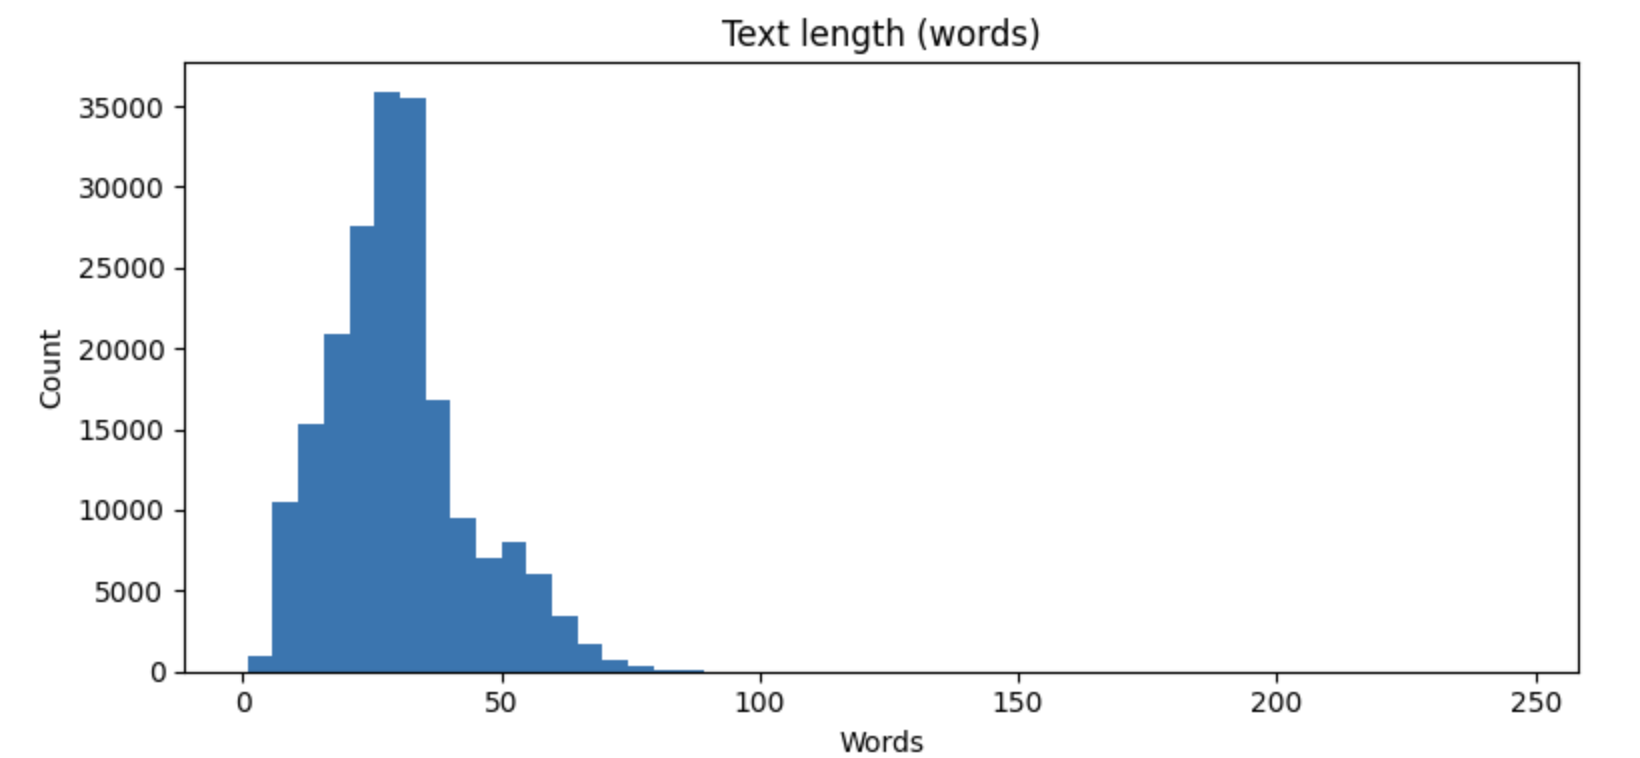

So we went back and re-capped our max_length for our tokenized inputs, and re-ran the model on the new token maxes. Our result was a slight bump to **71.71 overall accuracy, with a Macro F1 score of 65.86%**

**Experiment 8 Results**

- **Accuracy: Accuracy: 0.7171 | Macro F1: 0.6586**

| Category               | Precision | Recall | F1-score | Support |
|------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT   | 0.799     | 0.697  | 0.745    | 1993    |
| BUSINESS & MONEY       | 0.600     | 0.690  | 0.642    | 764     |
| **COMEDY**                 | 0.473     | 0.589  | 0.525    | 516     |
| CRIME                  | 0.522     | 0.726  | 0.608    | 340     |
| EDUCATION              | 0.434     | 0.767  | 0.555    | 215     |
| ENVIRONMENT            | 0.507     | 0.698  | 0.588    | 394     |
| FAMILY & RELATIONSHIPS | 0.827     | 0.791  | 0.808    | 1962     |
| FOOD & DRINK           | 0.786     | 0.868  | 0.825    | 832     |
| HEALTH & WELLNESS      | 0.832     | 0.729  | 0.777    | 2591    |
| HOME & LIVING          | 0.790     | 0.870  | 0.828    | 416     |
| **IMPACT**                 | 0.337     | 0.504  | 0.404    | 345     |
| ***MEDIA***                  | 0.457     | 0.740  | 0.565    | 281     |
| *OTHER NEWS*             | 0.486     | 0.541  | 0.512    | 407     |
| POLITICS               | 0.902     | 0.675  | 0.772    | 3272   |
| RELIGION               | 0.535     | 0.776  | 0.634    | 255     |
| SCIENCE                | 0.561     | 0.633  | 0.595    | 218     |
| SPORTS                 | 0.689     | 0.875  | 0.771    | 489     |
| *STYLE*                  | 0.358     | 0.747  | 0.484    | 225     |
| STYLE & BEAUTY         | 0.854     | 0.828  | 0.840    | 951     |
| *TECH*                   | 0.425     | 0.640  | 0.511    | 203     |
| TRAVEL                 | 0.798     | 0.859  | 0.828    | 989     |
| **VOICES & IDENTITY**      | 0.714     | 0.533  | 0.610    | 1536    |
| WORLD NEWS             | 0.723     | 0.723  | 0.723    | 842     |

**Experiment 9: Drop 'Impact' column, train a pre-model, re-classify the impact category as other other categories, append these new inputs to the rest of the original dataset (where we had dropped the original impact column), then train a fresh model on the resulting  *whole* dataset.**


Up until this point, the "IMPACT" column had been a silent scourge in our test results. No matter what architecture change, callback implementation, data augmentation procedure, etc. we had tried, this category remained stubbornly resistant to our modeling efforts (Consistently remaining in the 45-55% recall range and 30 - 40% precision range). As the numbers would suggest, any model we tried was struggling to identify this category. In order to investigate, we first tried to look at a subset of samples in order to identify what this category represented from a semantic perspective:





In [67]:
df_eda[df_eda['category'].str.contains("IMPACT")][['category', 'headline', 'short_description']].head(5)

,category,headline,short_description
12,IMPACT,"With Its Way Of Life At Risk, This Remote Oyst...",The revolution is coming to rural New Brunswick.
66,IMPACT,Monsanto And Bayer Are Set To Merge. Here's Wh...,“Together they will influence markets all over...
125,IMPACT,You're Going To Use That Self-Checkout Machine...,"We may not realize it, but retailers are condi..."
193,IMPACT,Machines Don't Always Steal Our Jobs. Increasi...,Your next boss could be an algorithm
286,IMPACT,She Started A Suicide Prevention Site At Age 1...,“People didn’t view me seriously because I was...


According to our manual checking, the broad categories of the first 5 samples were:
- Oysters in Canada
- Monsanto (Business?)
- Self-Checkout (Ostensibly Retail and Business?)
- AI is taking our jobs? (Business?)
- Mental Health Awareness (Health and Wellness / Politics?)

Upon further investigation, we found that the categories no longer existed on the HuffPost website, and when we researched the matter further, we found that this category corresponds to a section that was originally dedicatied in 2010 to "promote charitable causes and issues". Furthermore, content for the section was outsourced to Causecast, a philanthropy company, and it would feature any number of issues that Causecast deemed would drive activism for different causes they either believed in and / or sponsored. For a classification task, this is very problematic, as these 'causes' could represent anything the editors at Causecast wanted to draw attention to. So the challenge was to come up with a remediation strategy to deal with a category that could technically relate to anything, but was also not dedicated to any one category in and of itself. We couldn't manually classify each post as there were over 3,000 of them (and this is an ML course), but the idea struck us to pre-train a model on data NOT including the impact section, use that model to classify the ~3,000 IMPACT articles into other categories, and then take these re-classified results along with the original dataset (sans the IMPACT articles) to train a new, better performing model.

And that's just what we did, with us using our best model (from Experiment 7), pre-trained on the dataset with the impact removed to then predict categories for each of the impact articles, which we then used in conjunction with our other data to train our ellusive 'final model'. Our results were as follows. When we trained a model with the IMPACT category removed, our results attained a *massive* boost, with **overall accuracy jumping to 77.01%, and Macro F1 Recall jumping to 74.34% respectively**. This was extremely encouraging news to us as the removal of one category representing around ~ 1.5% of the overall dataset spiking performance to a large degree. We then used this resulting model to 'go back' and predict the classes that each of the IMPACT articles would have been in if the original 'impact' category never would have existed.

#### **Pre-Trained Results (Best Run)**
- **Accuracy: 0.7701, Macro F1: 0.7434**

| Category                 | Precision | Recall | F1-Score | Support |
|--------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT     | 0.848     | 0.681  | 0.755    | 2000    |
| BUSINESS & MONEY         | 0.683     | 0.696  | 0.690    | 807     |
| COMEDY                   | 0.540     | 0.671  | 0.598    | 519     |
| CRIME                    | 0.600     | 0.888  | 0.716    | 347     |
| EDUCATION                | 0.490     | 0.887  | 0.631    | 240     |
| ENVIRONMENT              | 0.638     | 0.856  | 0.731    | 418     |
| FAMILY & RELATIONSHIPS   | 0.859     | 0.799  | 0.828    | 1982    |
| FOOD & DRINK             | 0.843     | 0.926  | 0.883    | 837     |
| HEALTH & WELLNESS        | 0.893     | 0.729  | 0.803    | 2641    |
| HOME & LIVING            | 0.801     | 0.952  | 0.870    | 419     |
| MEDIA                    | 0.495     | 0.870  | 0.631    | 284     |
| OTHER NEWS               | 0.648     | 0.761  | 0.700    | 422     |
| POLITICS                 | 0.920     | 0.680  | 0.782    | 3291    |
| RELIGION                 | 0.631     | 0.918  | 0.748    | 268     |
| SCIENCE                  | 0.531     | 0.929  | 0.675    | 224     |
| SPORTS                   | 0.707     | 0.944  | 0.808    | 496     |
| STYLE                    | 0.466     | 0.934  | 0.622    | 227     |
| STYLE & BEAUTY           | 0.913     | 0.878  | 0.895    | 952     |
| TECH                     | 0.480     | 0.953  | 0.638    | 214     |
| TRAVEL                   | 0.872     | 0.917  | 0.894    | 997     |

Unfortunately, our exitement was short lived, as **when we added the re-classified IMPACT records back in, they dropped the relative performance of the second model back down to 72.09 % in performance.** (And as this was just an experiment, we did not save the weights). Fortunately, however, our final model based on the re-classified results was consistantly a top performer, and this combined with its functionality made it a great candidate for our 'final' model. 


**Final Model Results**

**Accuracy:** 0.7209 | **Macro F1:** 0.6695  

| Category                 | Precision | Recall | F1-Score | Support |
|--------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT     | 0.775     | 0.689  | 0.730    | 2000    |
| BUSINESS & MONEY         | 0.586     | 0.715  | 0.644    | 811     |
| COMEDY                   | 0.507     | 0.630  | 0.562    | 519     |
| CRIME                    | 0.511     | 0.768  | 0.614    | 349     |
| EDUCATION                | 0.416     | 0.697  | 0.521    | 251     |
| ENVIRONMENT              | 0.542     | 0.740  | 0.626    | 416     |
| FAMILY & RELATIONSHIPS   | 0.828     | 0.785  | 0.806    | 1986    |
| FOOD & DRINK             | 0.816     | 0.849  | 0.832    | 835     |
| HEALTH & WELLNESS        | 0.847     | 0.740  | 0.790    | 2626    |
| HOME & LIVING            | 0.742     | 0.874  | 0.803    | 419     |
| MEDIA                    | 0.397     | 0.720  | 0.512    | 286     |
| OTHER NEWS               | 0.553     | 0.490  | 0.520    | 416     |
| POLITICS                 | 0.922     | 0.630  | 0.749    | 3296    |
| RELIGION                 | 0.475     | 0.838  | 0.607    | 266     |
| SCIENCE                  | 0.462     | 0.646  | 0.538    | 223     |
| SPORTS                   | 0.693     | 0.901  | 0.784    | 496     |
| STYLE                    | 0.386     | 0.748  | 0.509    | 226     |
| STYLE & BEAUTY           | 0.832     | 0.881  | 0.856    | 952     |
| TECH                     | 0.453     | 0.750  | 0.565    | 212     |
| TRAVEL                   | 0.792     | 0.878  | 0.833    | 994     |
| VOICES & IDENTITY        | 0.710     | 0.508  | 0.592    | 1566    |
| WORLD NEWS               | 0.702     | 0.776  | 0.737    | 891     |


____